### <font color='cyan'> Sections in this notebook: <font>
I. Prerequisites 
    
    I.1. Importing modules, load data
    I.2. Cache necessary information about the data up front

II. Data understanding and cleaning

    II.1. Addressing missing data
        II.1.1. Let's get a feel for the missing data in the df first
        II.1.2. Special cases
    II.2. Format Conversion for certain columns
    II.3. Quasi-Constant Variables
        II.3.1 Numeric
        II.3.2. For all other columns
        II.3.3. Special cases
    II.4. Object type columns
    II.5. Deriving new columns 
    II.6. Data imputation
    II.7. Correlation
    II.8. Outlier Detection
        II.7.1 Box Plots
        II.7.2. IQR Analysis
    
III. Data Analysis:

    III.1. Univariate Analysis
    III.2. Bivariate analysis

# <font color='goldenrod'> I. Prerequisites </font>

### <font color='skyblue'>  I.1. Importing modules, load data<font>

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.feature_selection import VarianceThreshold

##### *1.1. Optional settings used for debugging.*

In [ ]:
pd.set_option('display.max_columns', 20)
#pd.set_option('display.max_rows', 200)
#pd.set_option('display.min_rows', 100)
#pd.set_option('display.expand_frame_repr', True)
pd.get_option("display.max_rows")

##### *1.2. Load data*

In [4]:
df = pd.read_csv("loan.csv", dtype={"next_pymnt_d": "string"}) # Explicitly specificying dtype for
                                                               # next_pymnt_d column, just to avoid pd warning

### <font color='skyblue'>  I.2. Cache necessary information about the data up front

 <font color="asparagus"> Cache the following info: 
 1. df dimension, will be used for different percentage based calculations
 2. df itself in a separate variable

In [5]:
df_loan = pd.read_csv("loan.csv", dtype={"next_pymnt_d": "string"})  # Caching original df, may be need it later for quick comparison

In [6]:
nDfShape = df.shape
nNoOfRows = nDfShape[0]
nNoOfCols = nDfShape[1]

# <font color='goldenrod'> II. Data understanding and cleaning </font>

### <font color='skyblue'>  II.1. Addressing missing data

#### II.1.1.  Let's get a feel for the missing data in the df first <br>
$\Rightarrow$ Instead of manually tackling each column, we will try to automate as much as possible

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(23), string(1)
memory usage: 33.6+ MB


$\Rightarrow$ <font color="asparagus"> The following function returns the #NaNs and #unique values in one column"

In [8]:
def get_columnInfo(df, column):
    return [df[column].isna().sum(), df[column].nunique()]

$\Rightarrow$ <font color="asparagus"> Store this information in a dictionary

In [9]:
columnInfo = {}
for col in df.columns:
    columnInfo[col] = get_columnInfo(df,col)

$\Rightarrow$ <font color="asparagus"> If a column has 60% missing values, we can drop it. This number can be smaller, but for this dataset 60% works

In [10]:
nNanThreshold = 0.6 

In [11]:
droppedCols = []
for col in df.columns:
    if (columnInfo[col][0]/nNoOfRows) >= nNanThreshold:
        print("Column ", col, end=" ")
        print("missing: ", round(100*columnInfo[col][0]/nNoOfRows,2), "%")
        droppedCols.append(col)

Column  mths_since_last_delinq missing:  64.66 %
Column  mths_since_last_record missing:  92.99 %
Column  next_pymnt_d missing:  97.13 %
Column  mths_since_last_major_derog missing:  100.0 %
Column  annual_inc_joint missing:  100.0 %
Column  dti_joint missing:  100.0 %
Column  verification_status_joint missing:  100.0 %
Column  tot_coll_amt missing:  100.0 %
Column  tot_cur_bal missing:  100.0 %
Column  open_acc_6m missing:  100.0 %
Column  open_il_6m missing:  100.0 %
Column  open_il_12m missing:  100.0 %
Column  open_il_24m missing:  100.0 %
Column  mths_since_rcnt_il missing:  100.0 %
Column  total_bal_il missing:  100.0 %
Column  il_util missing:  100.0 %
Column  open_rv_12m missing:  100.0 %
Column  open_rv_24m missing:  100.0 %
Column  max_bal_bc missing:  100.0 %
Column  all_util missing:  100.0 %
Column  total_rev_hi_lim missing:  100.0 %
Column  inq_fi missing:  100.0 %
Column  total_cu_tl missing:  100.0 %
Column  inq_last_12m missing:  100.0 %
Column  acc_open_past_24mths mi

#### <font color="asparagus"> *Observations and Comments*:<font> 
$\Rightarrow$ From the stdout above, **2** columns have 64.66% and 92.99% missing, while the remaining **54** have 100% missing data.<br> (We can just use dropna() but I like this approach, we can drop things above a threshold at the same time.) <br>
$\Rightarrow$ I have cached this in droppedCols. Let's further analyze and drop all these columns at once at the end right before k-variate analysis

#### II.1.2. Special cases: id, member_id and url are not features! <br>
#### <font color="asparagus"> *Each entry will be unique, whose description from the data dictionary supplied to us is as follows:*<font>
- member_id: A unique LC assigned Id for the borrower member.
- id: A unique LC assigned ID for the loan listing.
- url: URL for the LC page with listing data.<br>
<font color="asparagus"> $\Rightarrow$ *Side note*:<font>
    
- Even if all of *id* was not unique and there was repetition,  keeping *url* will still not make sense, since it only contains id information. 
Eg: For id: 1077501, the url is https://lendingclub.com/browse/loanDetail.action?loan_id=1077501. Really doesn't make sense to keep url.
- Add these three columns to the list of columns to be dropped
    

In [12]:
df.id.nunique(), df.member_id.nunique(), df.url.nunique() # Proving that the values are unique : ) 

(39717, 39717, 39717)

In [13]:
droppedCols.append("id")
droppedCols.append("member_id")
droppedCols.append("url")

### <font color='skyblue'>  II.1. Format Conversion for certain columns<font>
- term
- int_rate
- emp_length
- revol_util

##### <font color="asparagus"> $\Rightarrow$ 1. *term*:<font>

In [14]:
df.term.describe(), df.term.unique()

(count          39717
 unique             2
 top        36 months
 freq           29096
 Name: term, dtype: object,
 array([' 36 months', ' 60 months'], dtype=object))

##### <font color="asparagus"> $\Rightarrow$ *Makes sense removing the string " months" and storing it as an int*<font>

In [15]:
df.term = df.term.str.replace(" months", "")
df.term = df.term.astype(int)

In [16]:
df.term.unique()

array([36, 60])

##### <font color="asparagus"> $\Rightarrow$ *Converting months to years* <font>

In [17]:
df.term = df.term//12

In [18]:
df.term.unique()

array([3, 5])

##### <font color="asparagus"> $\Rightarrow$ 2. *int_rate*:<font> 

In [19]:
df.int_rate.describe()

count      39717
unique       371
top       10.99%
freq         956
Name: int_rate, dtype: object

##### <font color="asparagus"> $\Rightarrow$ *We can get rid of the %* <font>

In [20]:
df.int_rate = df.int_rate.str.replace("%","")

In [21]:
df.int_rate = df.int_rate.astype(float)

##### <font color="asparagus"> $\Rightarrow$ 3. *emp_length* <font>

In [22]:
df.emp_length.unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

##### <font color="asparagus"> $\Rightarrow$ *We can get rid of "year" & "years"* <font>

In [23]:
df.emp_length = df.emp_length.str.replace(" years","")

In [24]:
df.emp_length = df.emp_length.str.replace(" year", "")

In [25]:
df.emp_length.unique()

array(['10+', '< 1', '1', '3', '8', '9', '4', '5', '6', '2', '7', nan],
      dtype=object)

In [26]:
df.emp_length = df.emp_length.str.replace("+","")

C:\Users\santvenk\AppData\Local\Temp\ipykernel_11732\3734452646.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.emp_length = df.emp_length.str.replace("+","")


In [27]:
df.emp_length.value_counts()

10     8879
< 1    4583
2      4388
3      4095
4      3436
5      3282
1      3240
6      2229
7      1773
8      1479
9      1258
Name: emp_length, dtype: int64

In [28]:
df.emp_length = df.emp_length.str.replace("< ","")

In [29]:
df.emp_length.value_counts()

10    8879
1     7823
2     4388
3     4095
4     3436
5     3282
6     2229
7     1773
8     1479
9     1258
Name: emp_length, dtype: int64

In [30]:
df.emp_length = df.emp_length.str.replace("10","11")

#### <font color="asparagus"> *Comments*:<font> 
$\Rightarrow$ I think it will be more meaningful to categorize this column into bins: Something like: 0-2, 2-4, 4-6, 6-8, 8-10 and >10

$\Rightarrow$ But before that let's handle the null values first. I'm just gonna fill it up with the mode value, since missing values % = 1075/39717, isn't much. 

In [33]:
df.emp_length.isna().sum()

1075

In [34]:
df.emp_length.mode()[0]

'11'

In [36]:
df.emp_length = df.emp_length.fillna(df.emp_length.mode()[0])

In [37]:
df.emp_length = df.emp_length.astype(int)

In [38]:
emp_length_categories_list = [0, 2, 4, 6, 8, 10, 12]
emp_length_labels_list = ["0-2", "2-4", "4-6", "6-8", "8-10", "> 10"]
df["emp_length_bins"] = pd.cut(df.emp_length, bins=emp_length_categories_list,
                              labels=emp_length_labels_list)

In [39]:
df.emp_length_bins.value_counts()

0-2     12211
> 10     9954
2-4      7531
4-6      5511
6-8      3252
8-10     1258
Name: emp_length_bins, dtype: int64

##### <font color="asparagus"> $\Rightarrow$ 3. *revol_util* <font>

In [40]:
df.revol_util.describe()

count     39667
unique     1089
top          0%
freq        977
Name: revol_util, dtype: object

In [41]:
df.revol_util = df.revol_util.str.replace("%","") # Getting rid of "%"

In [42]:
df.revol_util= df.revol_util.astype("float")

### <font color='skyblue'> II.3. Quasi-Constant Variables
* Inspired by [Towards Data Science blog on this topic](https://towardsdatascience.com/how-to-detect-constant-quasi-constant-features-in-your-dataset-a1ab7aea34b4)
* Check out [sklearn.feature_selection.VarianceThreshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html) for more info!

####  II.3.1. Numeric data <font>
#### <font color="asparagus"> $\Rightarrow$ Let's drop quasi-constant features where 95% of the values are similar or constant on all the numeric columns <font>

In [43]:
df_numeric = df.select_dtypes(include=np.number)

In [44]:
df_numeric.shape[1]

91

In [45]:
sel = VarianceThreshold(threshold=0.05)

sel.fit(df_numeric.iloc[:,:])


C:\Users\santvenk\Anaconda3\lib\site-packages\sklearn\feature_selection\_variance_threshold.py:104: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


VarianceThreshold(threshold=0.05)

#### <font color="asparagus"> *Comments*:<font>
$\Rightarrow$ Once it is fit, the support of the vector, sel will give me all the retained features.<br>
$\Rightarrow$ Therefore anything that does not appear in df.columns[support()] are *quasi-constant*
    

In [46]:
quasi_constant_features_list = [x for x in df_numeric.columns if x not in df_numeric.columns[sel.get_support()]]


In [47]:
len(quasi_constant_features_list), quasi_constant_features_list

(61,
 ['collections_12_mths_ex_med',
  'mths_since_last_major_derog',
  'policy_code',
  'annual_inc_joint',
  'dti_joint',
  'verification_status_joint',
  'acc_now_delinq',
  'tot_coll_amt',
  'tot_cur_bal',
  'open_acc_6m',
  'open_il_6m',
  'open_il_12m',
  'open_il_24m',
  'mths_since_rcnt_il',
  'total_bal_il',
  'il_util',
  'open_rv_12m',
  'open_rv_24m',
  'max_bal_bc',
  'all_util',
  'total_rev_hi_lim',
  'inq_fi',
  'total_cu_tl',
  'inq_last_12m',
  'acc_open_past_24mths',
  'avg_cur_bal',
  'bc_open_to_buy',
  'bc_util',
  'chargeoff_within_12_mths',
  'delinq_amnt',
  'mo_sin_old_il_acct',
  'mo_sin_old_rev_tl_op',
  'mo_sin_rcnt_rev_tl_op',
  'mo_sin_rcnt_tl',
  'mort_acc',
  'mths_since_recent_bc',
  'mths_since_recent_bc_dlq',
  'mths_since_recent_inq',
  'mths_since_recent_revol_delinq',
  'num_accts_ever_120_pd',
  'num_actv_bc_tl',
  'num_actv_rev_tl',
  'num_bc_sats',
  'num_bc_tl',
  'num_il_tl',
  'num_op_rev_tl',
  'num_rev_accts',
  'num_rev_tl_bal_gt_0',
  'n

#### <font color="asparagus"> $\Rightarrow$ Remember, we already have identified many columns to be dropped, so there might be an overlap. So let's check the newly identified columns

In [48]:
newly_identified_cols = [col for col in quasi_constant_features_list if col not in droppedCols]

#### <font color="asparagus"> $\Rightarrow$ The names of the newly identified columns are:

In [49]:
newly_identified_cols

['collections_12_mths_ex_med',
 'policy_code',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'pub_rec_bankruptcies',
 'tax_liens']

#### <font color="asparagus"> $\Rightarrow$ If you look at the unique values of these newly identified columns, you would find that besides pub_rec_bankruptcies, the others are straight up constants and not just quasi-constant.<br><font>
#### <font color="asparagus"> $\Rightarrow$ Either way, it makes sense to drop these columns too

In [50]:
[df[col].nunique() for col in newly_identified_cols]
    

[1, 1, 1, 1, 1, 3, 1]

In [51]:
[droppedCols.append(col) for col in newly_identified_cols]

[None, None, None, None, None, None, None]

#### II.3.2 For all other columns

#### <font color="asparagus"> $\Rightarrow$ columnInfo already has the number of unique values for each column, we had cached it earlier.<font>
#### <font color="asparagus"> $\Rightarrow$ Now is the time to add any column that has only **one** unique to the list of columns to be dropped : ) <font>

In [52]:
# [droppedCols.append(col) if (df[col].nunique() == 1 & col not in droppedCols) for col in columnInfo] List comprehension to do this..
print("The following columns have only 1 value throughout the data")
for col in columnInfo:
    if (df[col].nunique() == 1) & (col not in droppedCols):
        print(f"col: {col} ")
        droppedCols.append(col)

The following columns have only 1 value throughout the data
col: pymnt_plan 
col: initial_list_status 
col: application_type 


#### II.3.3. Special Cases
#### <font color="asparagus"> $\Rightarrow$ It's important to note that *desc* column is pointless to have. It contains sentences and words that the borrower filled out when asking for a loan. Now we already have a column called *purpose* which as the name implies holds the purpose for which the loan was taken.<font>
#### <font color="asparagus"> $\Rightarrow$It has 7 unique values, so we will stick with *purpose* column and drop *desc* altogether, unless we want to do sentiment analysis : )<font>

In [53]:
df.desc.unique() # Just an example of the contents of desc column

array(['  Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>',
       '  Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up.<br><br>  Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces<br>',
       nan, ...,
       'Our current gutter system on our home is old and in need of repair.    We will be using the borrowed funds to replace the gutter system on our home.',
       'The rate of interest and fees incurred by carrying a balance on my credit card are so outrageous at this point that continuing

In [54]:
droppedCols.append("desc")

#### <font color="asparagus"> *Comments*: <br> $\Rightarrow$ Finally, let's drop all the columns we have accumulated so far <font>

In [61]:
nNoOfCols = df.shape[1]
print(nNoOfCols)

41


In [57]:
print(f"Number of columns to be dropped {len(set(droppedCols))}, Remainder: {nNoOfCols - len(set(droppedCols))}")

Number of columns to be dropped 71, Remainder: 40


In [56]:
df.drop(droppedCols,axis=1, inplace=True)

In [62]:
nNoOfCols = df.shape[1] # Updating nNoOfCols

In [63]:
nNoOfCols

41

### <font color='skyblue'>  II.4. Object type columns <font>

#### <font color="asparagus"> *I generally do not like to leave object type columns as is. There could be some inconsistencies in the way data is filled.*<font> 
#### <font color="asparagus"> $\Rightarrow$ Let's sanitize them and explicitly convert them to appropriate formats <font>

In [64]:
df_object = df.select_dtypes(include="object")

#### <font color="asparagus"> Just checking what kind of values they take

In [65]:
for col in df_object.columns:
    print("col :", col, end=" ")
    print(columnInfo[col])

col : grade [0, 7]
col : sub_grade [0, 35]
col : emp_title [2459, 28820]
col : home_ownership [0, 5]
col : verification_status [0, 3]
col : issue_d [0, 55]
col : loan_status [0, 3]
col : purpose [0, 14]
col : title [11, 19615]
col : zip_code [0, 823]
col : addr_state [0, 50]
col : earliest_cr_line [0, 526]
col : last_pymnt_d [71, 101]
col : last_credit_pull_d [2, 106]


#### <font color="asparagus"> Don't want to flood stdout, just printing the unique values for columns with less than 16 unique values <font>

In [66]:
for col in df_object.columns:
    if columnInfo[col][1] <= 15:
        print("col :", col, end=" ")
        print(df[col].unique())

col : grade ['B' 'C' 'A' 'E' 'F' 'D' 'G']
col : home_ownership ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE']
col : verification_status ['Verified' 'Source Verified' 'Not Verified']
col : loan_status ['Fully Paid' 'Charged Off' 'Current']
col : purpose ['credit_card' 'car' 'small_business' 'other' 'wedding'
 'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
 'moving' 'vacation' 'house' 'renewable_energy' 'educational']


#### <font color="asparagus"> All of these columns can first be converted to string type, since none of them have any other problems <font>

In [67]:
for col in df_object.columns:
    df[col] = df[col].astype("string")

### <font color='skyblue'>  II.6. Deriving new columns
    

##### <font color="asparagus"> We've already converted term in months to years. Now let's look at other columns. Starting with: <font>
##### <font color="asparagus"> $\Rightarrow$ 1. *annual_inc*:<font>
<font color="asparagus"> I think we can get a good analysis if we successfully categorize this column into bins of 20000 dollars. 

In [68]:
df.annual_inc.describe()

count    3.971700e+04
mean     6.896893e+04
std      6.379377e+04
min      4.000000e+03
25%      4.040400e+04
50%      5.900000e+04
75%      8.230000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

##### <font color="asparagus"> $\Rightarrow$ Just checking few things about the annual_inc column <font>

In [69]:
np.quantile(df.annual_inc,0.99) ## 99% of the borrowers have annual inc < $234,000

234999.36

In [70]:
len(df[(df.annual_inc > np.quantile(df.annual_inc,0.99))])

398

##### <font color="asparagus"> $\Rightarrow$ There are still 43 borrowers(out of 398) whose income is in the top 1%, yet they defaulted. > 10%

In [71]:
len(df[(df.annual_inc > np.quantile(df.annual_inc,0.99)) & (df.loan_status == "Charged Off")])

43

In [72]:
annual_inc_categories_list = [0, 20000, 40000, 60000, 80000, 100000, 6000000]
annual_inc_labels_list = ["0-20", "20-40", "40-60", "60-80", "80-100", "> 100"]
df["annual_inc_bins"] = pd.cut(df.annual_inc, bins=annual_inc_categories_list,
                              labels=annual_inc_labels_list)

In [73]:
df.annual_inc_bins.value_counts()

40-60     11608
20-40      8688
60-80      7861
> 100      5687
80-100     4684
0-20       1189
Name: annual_inc_bins, dtype: int64

##### <font color="asparagus"> $\Rightarrow$ 2. *funded_amnt*:<font>
<font color="asparagus"> I think we can get a good analysis if we successfully categorize this column as well.

In [74]:
df.funded_amnt.describe()

count    39717.000000
mean     10947.713196
std       7187.238670
min        500.000000
25%       5400.000000
50%       9600.000000
75%      15000.000000
max      35000.000000
Name: funded_amnt, dtype: float64

In [75]:
funded_amnt_categories_list = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]
funded_amnt_labels_list = ["0-5", "5-10", "10-15", "15-20", "20-25", "25-30", "30-35", "35-40"]
df['funded_amnt_bins'] = pd.cut(df.funded_amnt, bins=funded_amnt_categories_list,
                              labels=funded_amnt_labels_list)

In [76]:
df.funded_amnt_bins.value_counts()

5-10     13161
0-5       9651
10-15     8178
15-20     4597
20-25     2719
25-30      725
30-35      686
35-40        0
Name: funded_amnt_bins, dtype: int64

##### <font color="asparagus"> $\Rightarrow$ 3. *int_rate*:<font>
<font color="asparagus"> I think we can get a good analysis if we successfully categorize this column as well.

In [77]:
int_rate_range_list = [0, 8, 10, 12, 14, 16, 20]
int_rate_labels_list = ["0-8", "8-10", "10-12", "12-14", "14-16", ">16"]
df["int_rate_bins"] = pd.cut(df["int_rate"], bins=int_rate_range_list, labels=int_rate_labels_list)

In [78]:
df["int_rate_bins"].value_counts()

10-12    8576
0-8      8233
12-14    7469
14-16    5410
>16      4997
8-10     4160
Name: int_rate_bins, dtype: int64

### <font color='skyblue'>  II.6. Data Imputation for missing rows

In [79]:
df.isna().sum()

loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_title                  2459
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
purpose                       0
title                        11
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                   50
total_acc                     0
out_prncp                     0
out_prncp_inv                 0
total_pymnt                   0
total_py

#### <font color="asparagus"> Low hanging fruits: <font>
1. title 
2. revol_util
3. last_pymnt_d
4. last_credit_pull_d
5. emp_length
- Come back to emp_length later <font color="red"> TO DO!

##### <font color="asparagus"> $\Rightarrow$ 1. *title*<font> 
- Only 11/39717 have missing values, we can impute using value of mode 

In [80]:
df.title.fillna(df.title.mode()[0], inplace=True)

##### <font color="asparagus"> $\Rightarrow$ 2. *revol_util*<font> 
- Only 50/39717 have missing values, we can impute using value of mode 

In [81]:
df.revol_util.fillna(df.revol_util.mode()[0], inplace=True)

##### <font color="asparagus"> $\Rightarrow$ 3. *last_pymnt_d*<font> 
- Only 71/39717 have missing values, we can impute using value of mode 

In [82]:
df.last_pymnt_d.fillna(df.last_pymnt_d.mode()[0], inplace=True)

##### <font color="asparagus"> $\Rightarrow$ 4. *last_credit_pull_d*<font> 
- Only 2/39717 have missing values, we can impute using value of mode 

In [83]:
df.last_credit_pull_d.fillna(df.last_credit_pull_d.mode()[0], inplace=True)

In [84]:
df.isna().sum()

loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_title                  2459
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
purpose                       0
title                         0
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
out_prncp                     0
out_prncp_inv                 0
total_pymnt                   0
total_py

##### <font color="asparagus"> $\Rightarrow$ 5. *emp_length* <font>
- Though it has more missing values than the above ones we just discussed 1075/39717, isn't much. This column is categorical, plus it seems the company has more 10+ experience borrowers. We can fill with mode

<font color="red"> TO DO! collection_recovery_fee is 90% the same value... i.e. 0<br>
Outliers removal<font>

### <font color='skyblue'>  II.6. Correlation<font>

#### <font color="asparagus"> *Need to create a heatmap of all the retained numeric variables and check the relationship* <font>

In [85]:
# Define the heatmap parameters
pd.options.display.float_format = "{:,.2f}".format

In [86]:
df_numeric = df.select_dtypes(include=np.number)

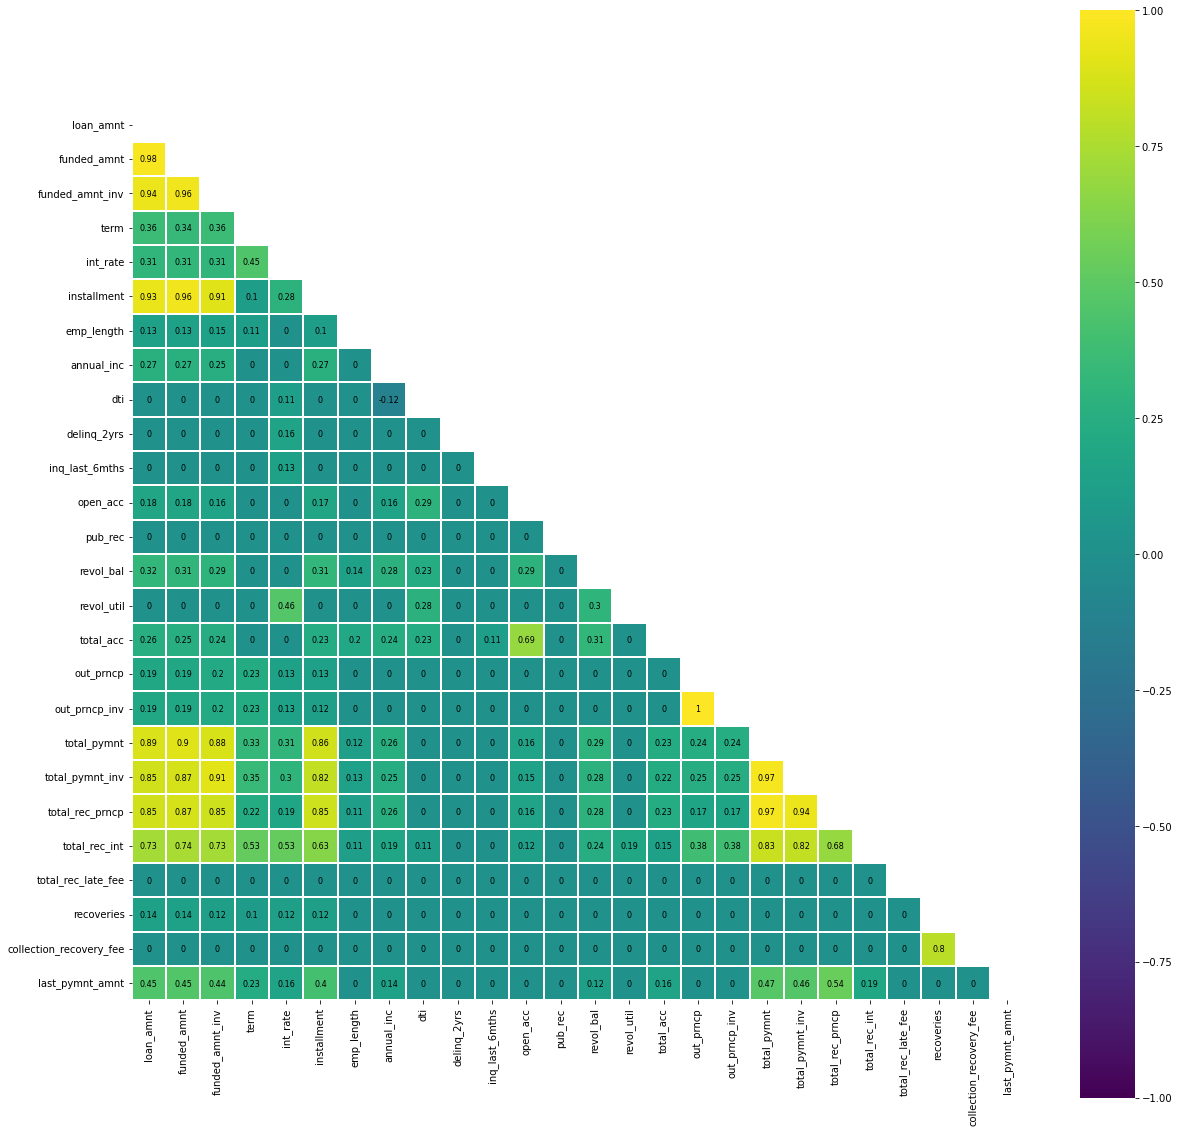

In [87]:
corr_mat = df_numeric.corr()

# Mask the upper part of the heatmap
mask = np.triu(np.ones_like(corr_mat, dtype=bool))

# Choose the color map
cmap = "viridis"

corr_mat[(corr_mat < 0.1) & (corr_mat > -0.1)] = 0 # Easier to view, don't really care obout weak correlations
# plot the heatmap
plt.figure(figsize=(20,20))
sns.heatmap(corr_mat, mask=mask, vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot_kws={"size": 8, "color": "black"}, square=True, cmap=cmap, annot=True)
plt.show()

#### <font color="asparagus"> 1. We need to make a decision on these highly correlation variables.<font> 
#### <font color="asparagus"> 2. No need to keep them all, rather, we can discard all but one and continue <font>

##### Strengh of relationship

* |r| < 0.3 $\Rightarrow$ None or Very Weak
* 0.3 < |r| < 0.5 $\Rightarrow$ Weak
* 0.5 < |r| < 0.7 $\Rightarrow$ Moderate
* |r| > 0.7 $\Rightarrow$ Strong

In [88]:
colsToDrop_fromCorr = [] # New list to maintain the columns we want to drop

#### <font color="asparagus"> $\Rightarrow$ *Focusing on funded_amount, loan_amount, funded_amount_inv first* <font>
1. loan_amnt: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
2. funded_amnt: The total amount committed to that loan at that point in time.
3. funded_amnt_inv: The total amount committed by investors for that loan at that point in time.<br>
The correlation factor, r, is almost 1 for these guys
    
In short, a borrower approaches the company to ask for an amount, *loan_amnt*. The company agrees for a certain amount, *funded_amnt*. *funded_amnt_inv*: Sometimes, the lending club themselves step in and fund the amount. This is that. <br>
$\Rightarrow$ Conclusion: We can just keep *funded_amnt* and discard the rest. <br>Because *loan_amnt* will satisfy the condition:
    *funded_amnt* <= *loan_amnt* 

    

In [89]:
colsToDrop_fromCorr.append("loan_amnt")
colsToDrop_fromCorr.append("funded_amnt_inv")

#### <font color="asparagus"> $\Rightarrow$ *Commenting on installment* <font>

#### *installment* is the monthly payment owed by the borrower if the loan originates as per the data dictionary. <br>
#### Again, r >0.9 with "loan_amnt", "funded_amnt", "funded_amnt_inv". <br>
#### Therefore, *installment* can be dropped as well.

In [90]:
colsToDrop_fromCorr.append("installment")

#### <font color="asparagus"> $\Rightarrow$ *Commenting on total_xx columns* <font>

#### <font color="asparagus"> 1. total_pymnt: Payments received to date for total amount funded<font>
#### <font color="asparagus"> 2. total_pymnt_inv: Payments received to date for portion of total amount funded by investors<font>
#### <font color="asparagus"> 3. total_rec_prncp: Principal received to date<font>
#### <font color="asparagus"> 4. total_rec_int: Interest received to date<font> 
##### <font color="asparagus"> $\Rightarrow$ We cannot drop total_pymnt, but as it stands, it does not give us good information about the borrower's current status of payment(how much left, how much paid). They are just raw numbers. <br>
##### <font color="asparagus"> $\Rightarrow$ What we can do instead is add a new column: Percentage of funded amount paid.
If a borrower pays the entire amount, the percentage will 100%. Formula: <br>(total_pymnt - total_rec_int - total_rec_late_fee)/funded_amnt.<br> 
#### *Side note*: These columns also show a high correlation with *"loan_amnt", "funded_amnt", "funded_amnt_inv"* (~0.75)<br>

**Conclusion**: We can hold on to *total_pymnt* and discard remaining. By the way, *funded_amnt* is highly correlated with *total_pymnt* as well
    

In [91]:
df["Pct_Payment_Received"] = round(100 * (df.total_pymnt - df.total_rec_int - df.total_rec_late_fee)/df.funded_amnt,2) 

In [92]:
colsToDrop_fromCorr.append("total_pymnt_inv")
colsToDrop_fromCorr.append("total_rec_prncp")
colsToDrop_fromCorr.append("total_rec_int")

In [93]:
colsToDrop_fromCorr


['loan_amnt',
 'funded_amnt_inv',
 'installment',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int']

#### <font color="asparagus"> $\Rightarrow$ *Commenting on (total_acc, open_acc): r = 0.69 and (collection_recovery_fee, recoveries)*: r = 0.8 <font>

#### 1. total_acc: The total number of credit lines currently in the borrower's credit file
#### 2. open_acc: The number of open credit lines in the borrower's credit file.

$\Rightarrow$ Makes sense that they are highly correlated. I think we can just **keep the number of open credit lines** and **drop the total**, because **total will include open and closed**. **We are only interested in the ones that are currently running**(this is where we can find whether the borrower is about to default or not)

In [94]:
colsToDrop_fromCorr.append("total_acc")

#### 1. recoveries: post charge off gross recovery
#### 2. collection_recovery_fee: post charge off collection fee<br>
$\Rightarrow$ Both of these quantities are concerned with post charge off scenarios. Most of the values are 0 for both of them as well. I think it is safe to drop recoveries

In [95]:
colsToDrop_fromCorr.append("recoveries")

In [96]:
colsToDrop_fromCorr

['loan_amnt',
 'funded_amnt_inv',
 'installment',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_acc',
 'recoveries']

In [97]:
df.drop(colsToDrop_fromCorr,axis=1,inplace=True)

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   funded_amnt              39717 non-null  int64   
 1   term                     39717 non-null  int32   
 2   int_rate                 39717 non-null  float64 
 3   grade                    39717 non-null  string  
 4   sub_grade                39717 non-null  string  
 5   emp_title                37258 non-null  string  
 6   emp_length               39717 non-null  int32   
 7   home_ownership           39717 non-null  string  
 8   annual_inc               39717 non-null  float64 
 9   verification_status      39717 non-null  string  
 10  issue_d                  39717 non-null  string  
 11  loan_status              39717 non-null  string  
 12  purpose                  39717 non-null  string  
 13  title                    39717 non-null  string  
 14  zip_co

In [99]:
nNoOfCols = df.shape[1]

In [100]:
nNoOfCols

37

### <font color='skyblue'>  II.7. Outlier Detection<font>
1. Box Plots<br>
2. Mahalanobis Distance

When describing relationship between two variables, correlations is necessary, but not sufficient. More plots will help

#### <font color="asparagus"> *Sequence*:<font>
$\Rightarrow$ <font color="asparagus"> Boxplot first then  
$\Rightarrow$ <font color="asparagus">  I'm gonnna calculate the IQRs for every column and store the locations of every row that lies outside the 1.5IQR range

### <font color='skyblue'>  II.7.1. Box Plots<font>

In [101]:
df_numeric = df.select_dtypes(include=np.number)

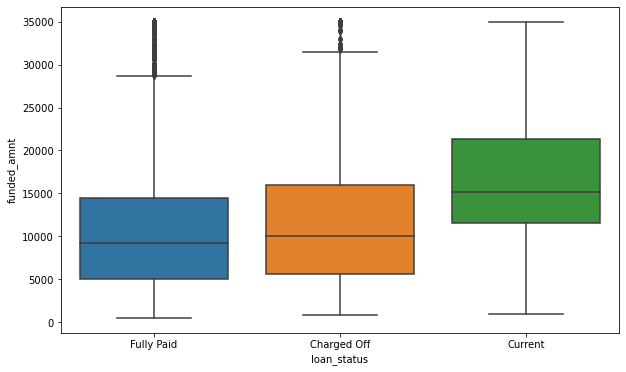

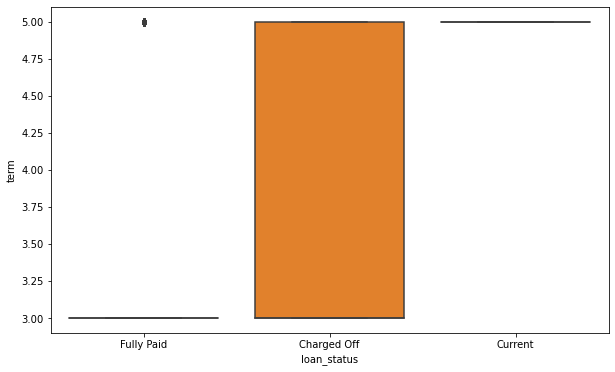

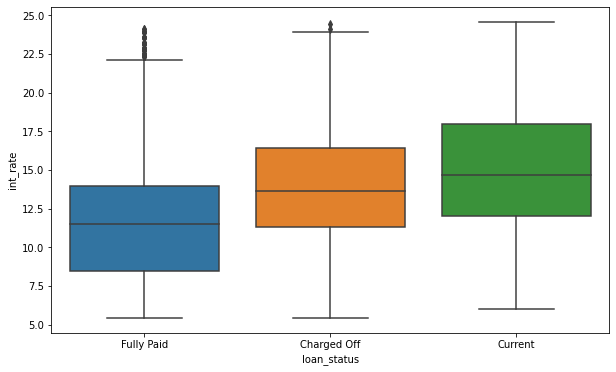

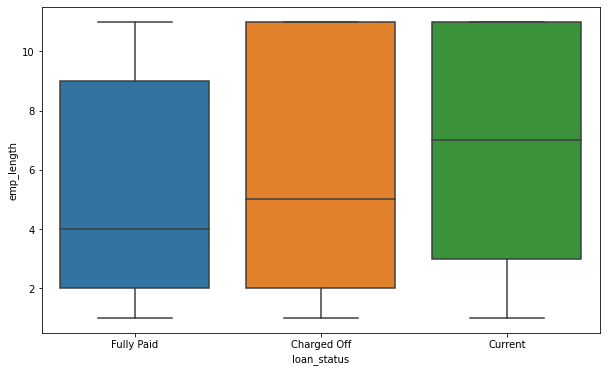

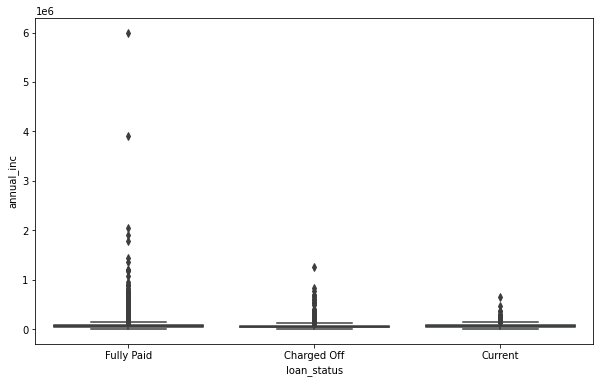

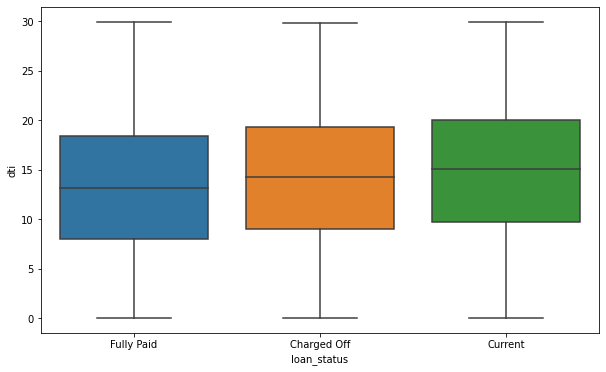

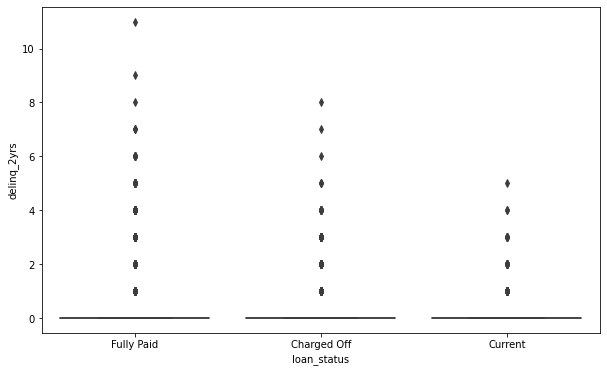

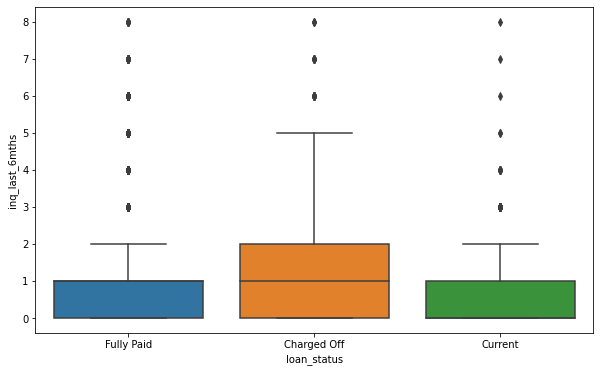

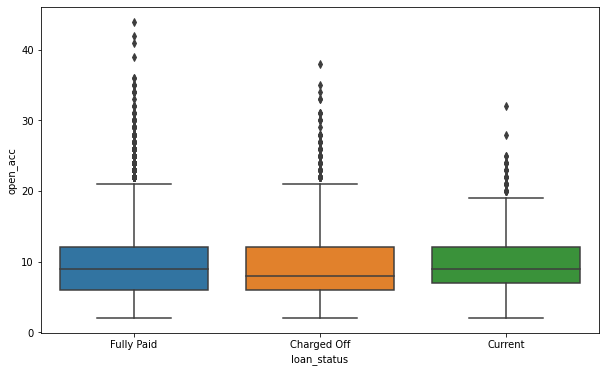

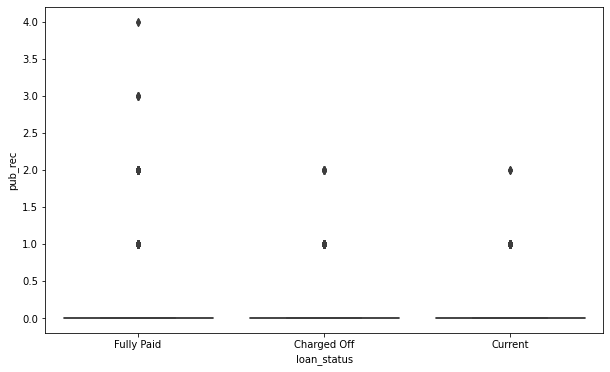

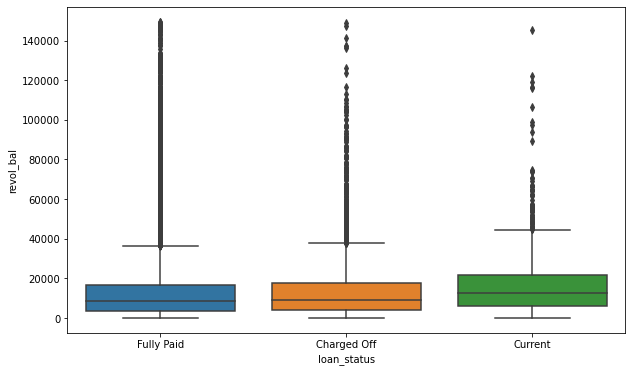

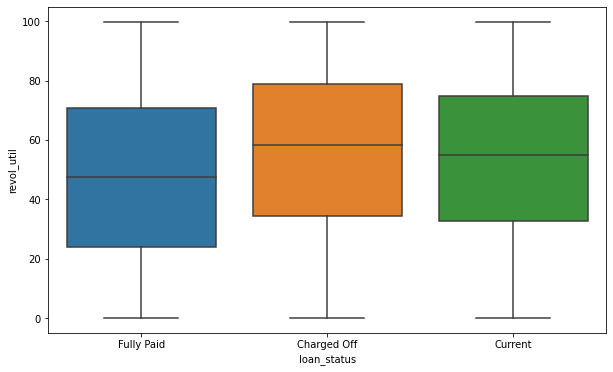

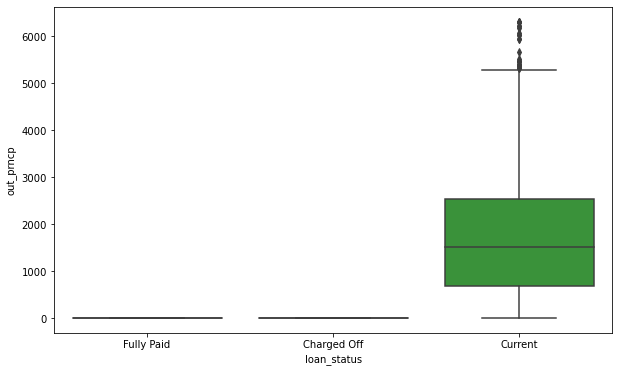

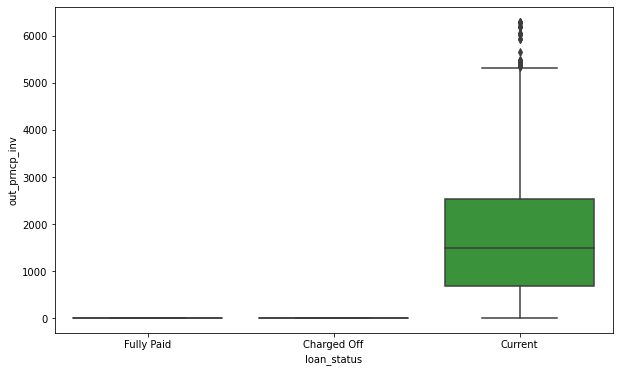

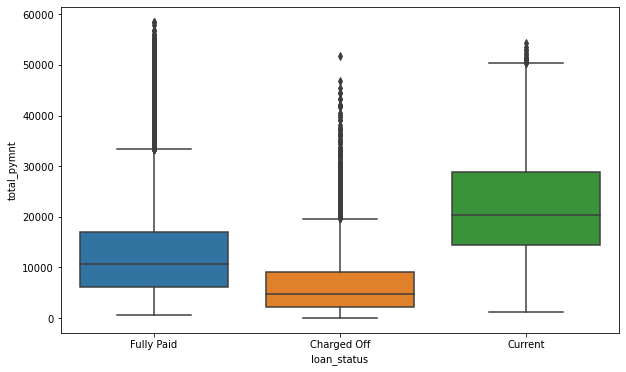

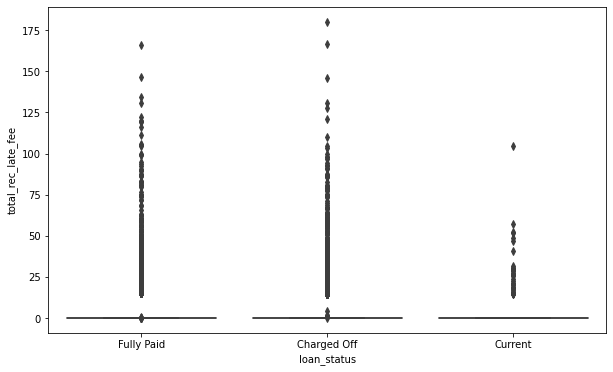

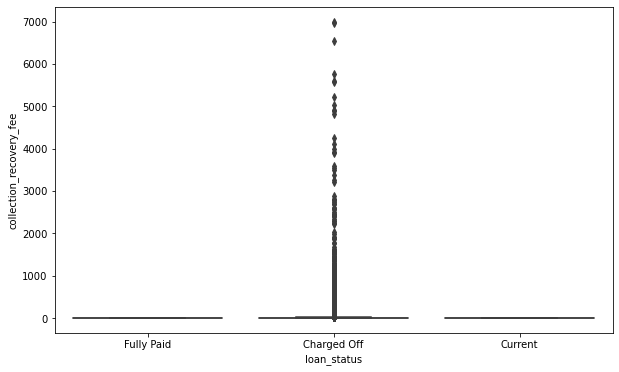

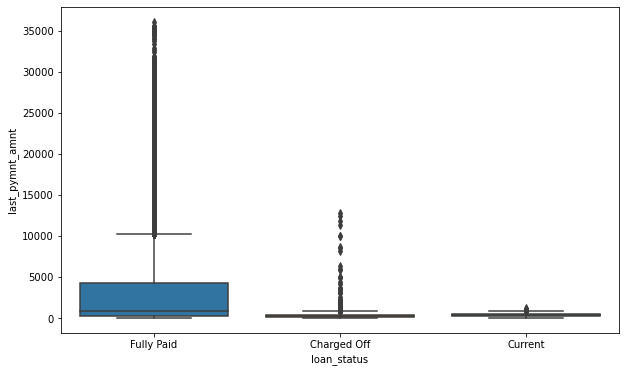

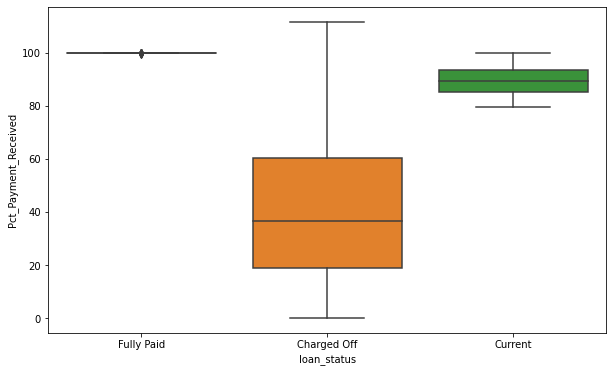

In [102]:
#fig, axes = plt.subplots(7,2,figsize=(20,30))
for col in df_numeric.columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(x="loan_status", y=col,
                data=df)
    plt.show()
    

#### <font color="asparagus"> *Observations and Comments*:<font> 
$\Rightarrow$ <font color="asparagus"> Looking at the box plot, it looks like the median(and range) of percentage_payment_received is the lowest for "Charged Off" borrowers. This is a good indicator for borrowers who are likely to default

In [103]:
indicators = []
indicators.append("Pct_Payment_Received")

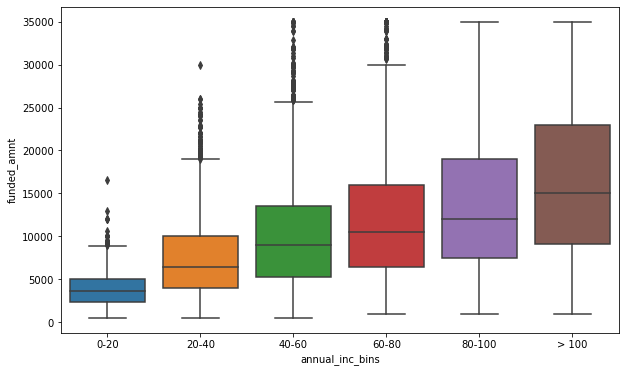

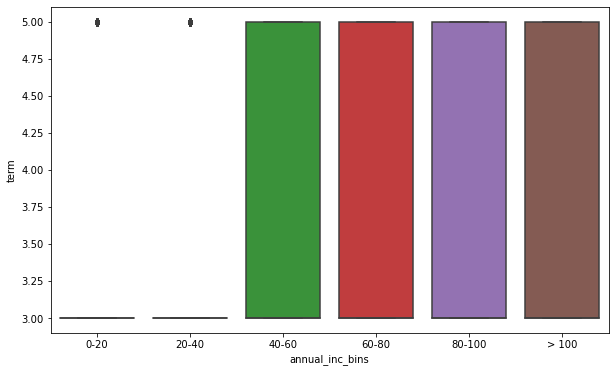

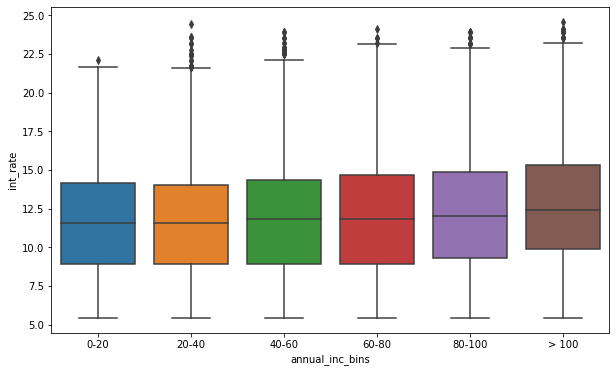

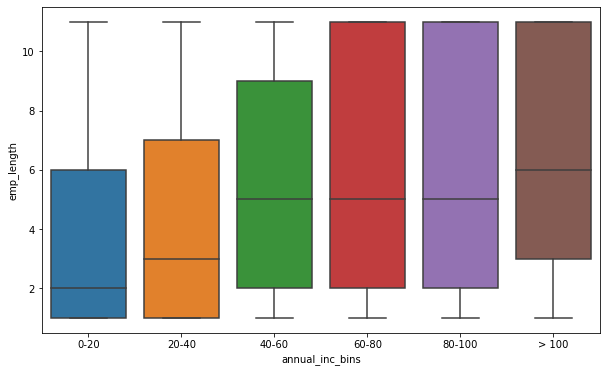

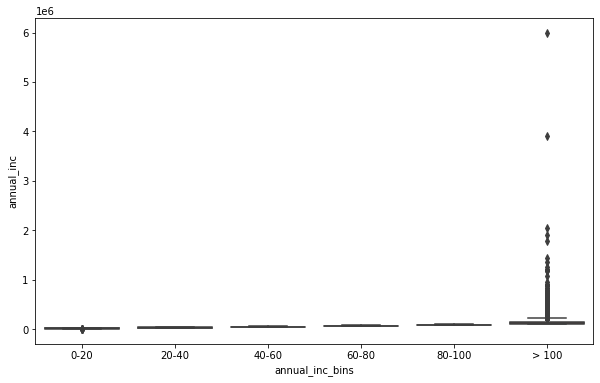

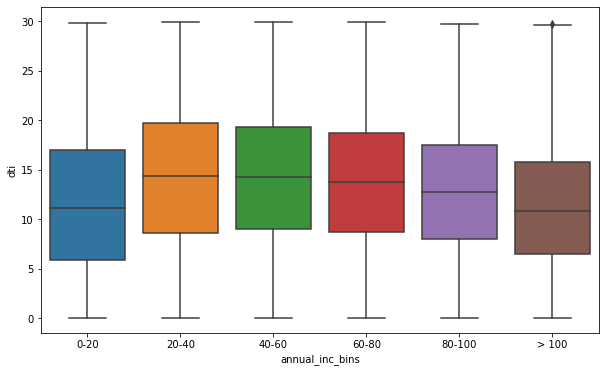

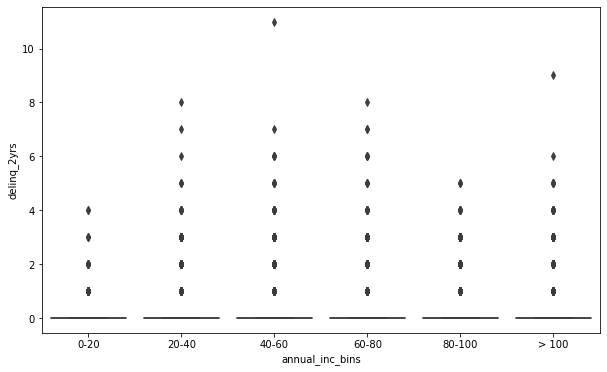

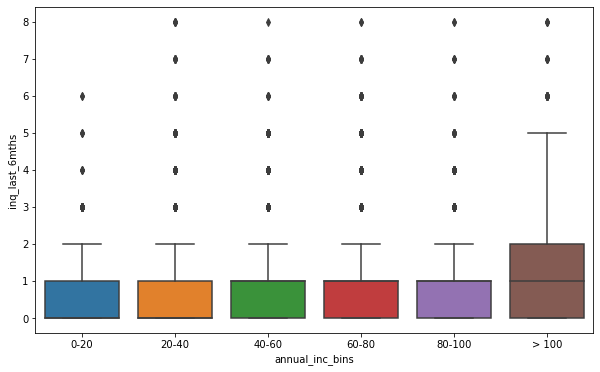

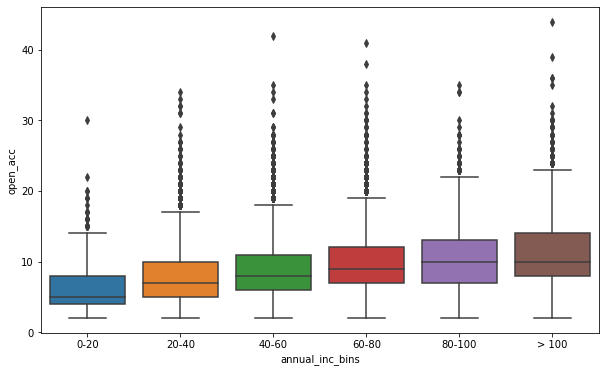

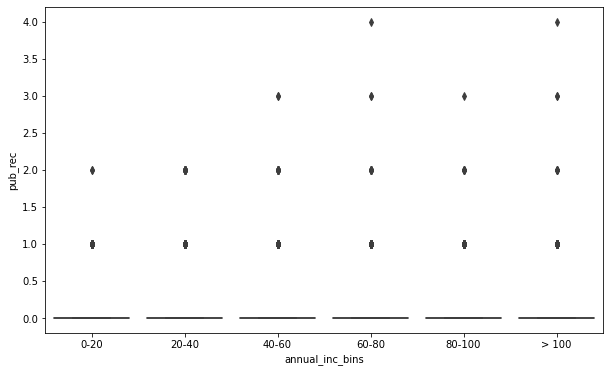

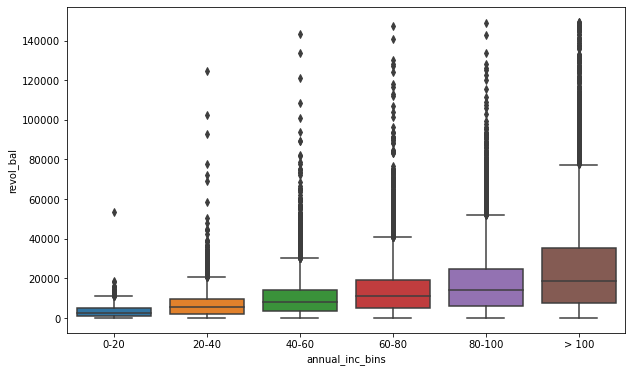

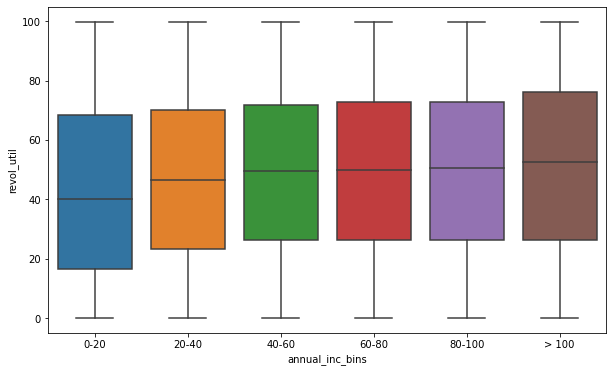

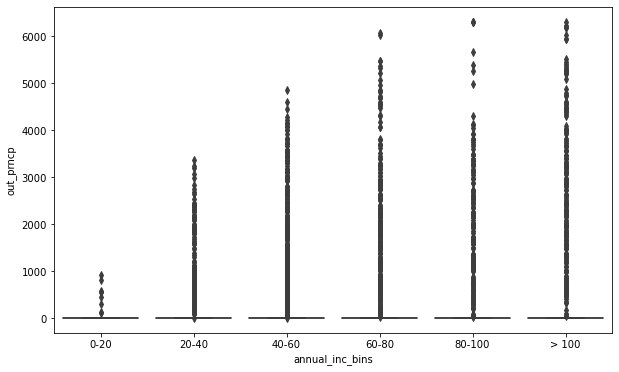

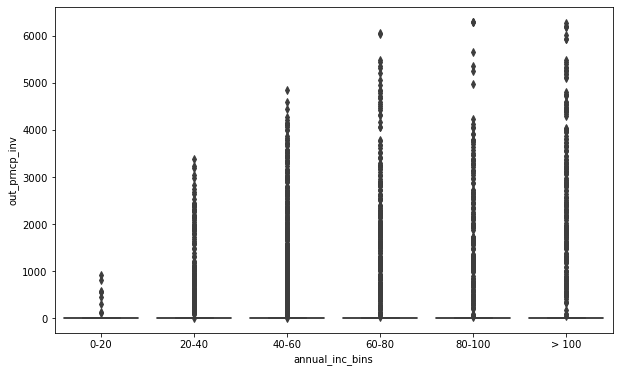

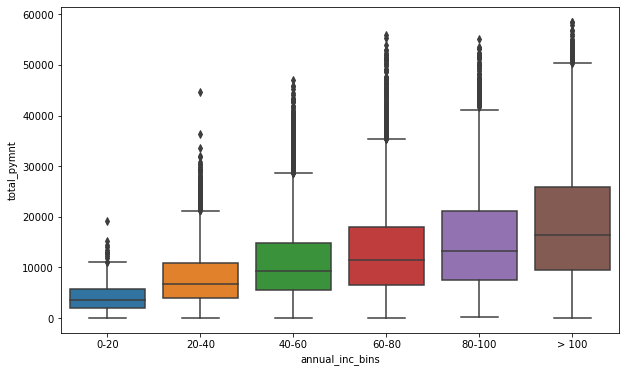

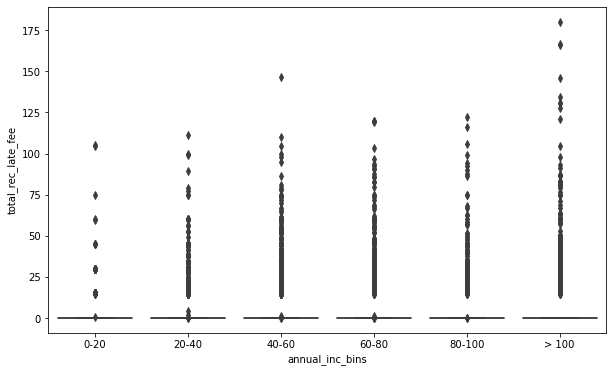

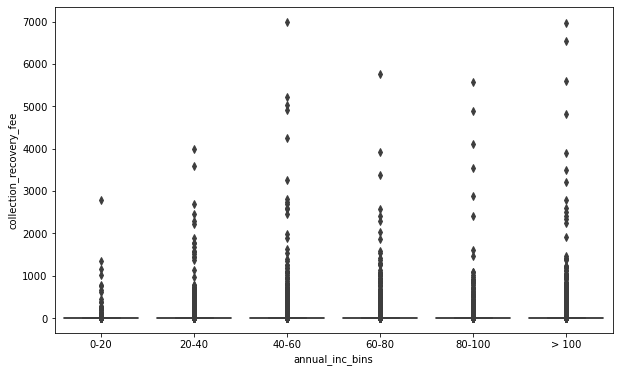

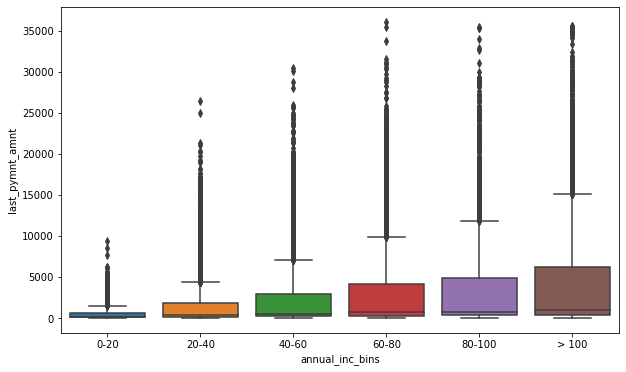

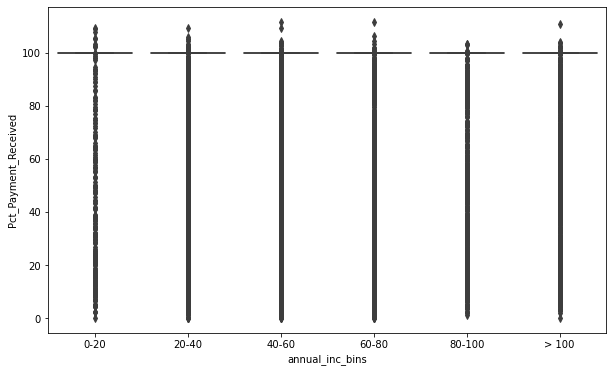

In [104]:
for col in df_numeric.columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(x="annual_inc_bins", y=col,
                data=df)
    plt.show()

#### <font color="asparagus"> *Observations and Comments*:<font> 
$\Rightarrow$ <font color="asparagus"> Borrowers with high income borrow the higest amount. They also have made more inquiries in the past 6 months as compared to others. They have a lot more open accounts than borrowers with lower income than them. <br> $\Rightarrow$ Since they tend to borrow more, the total payment received is also more. <font><br>

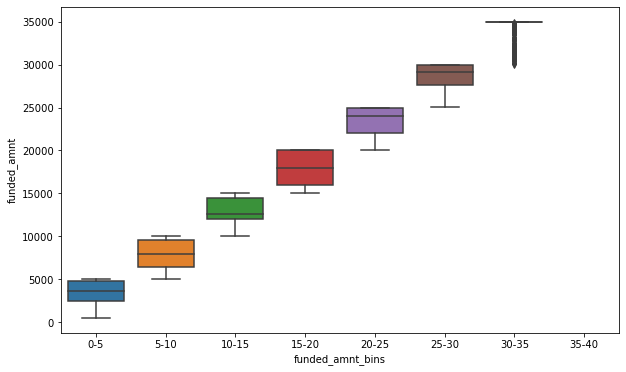

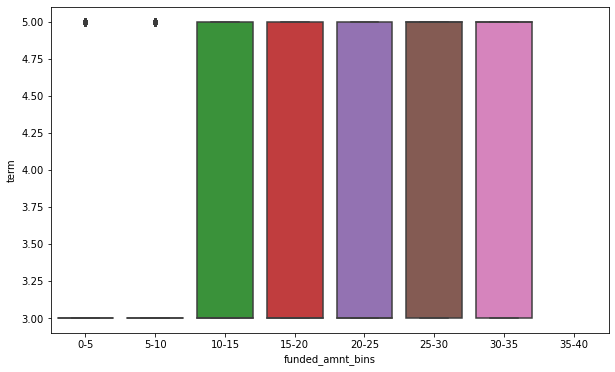

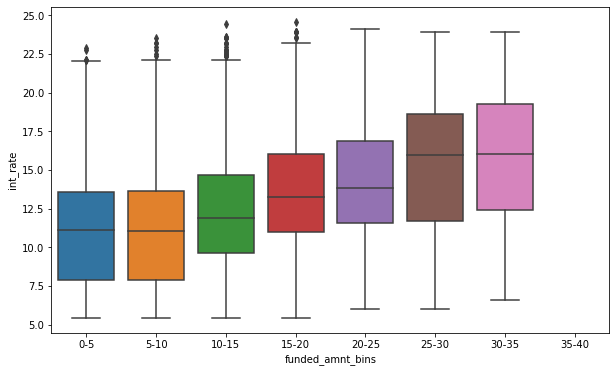

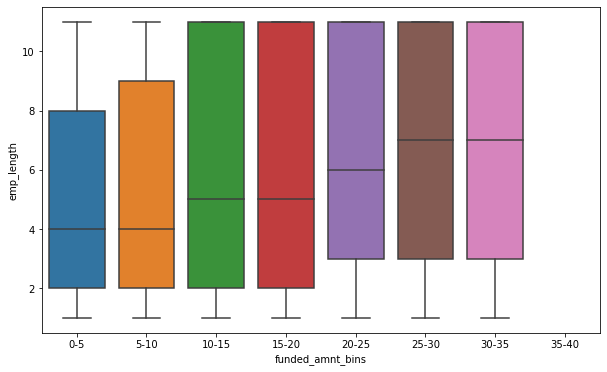

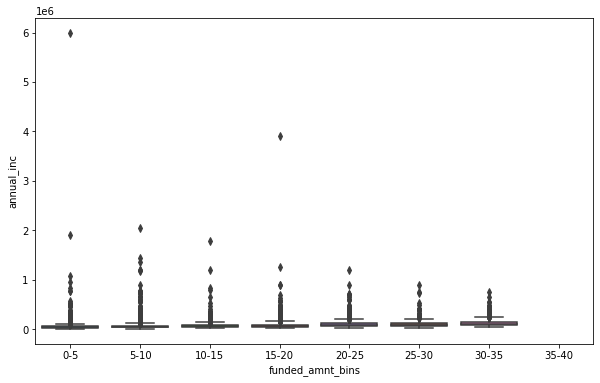

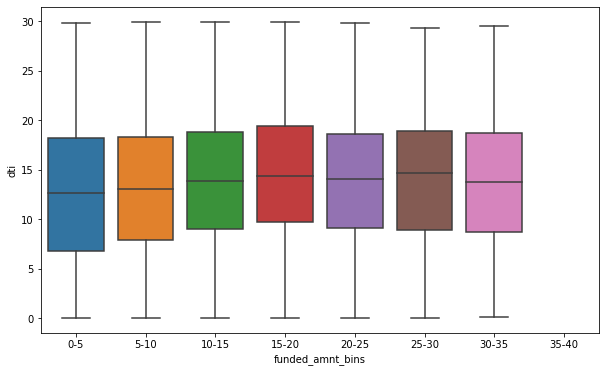

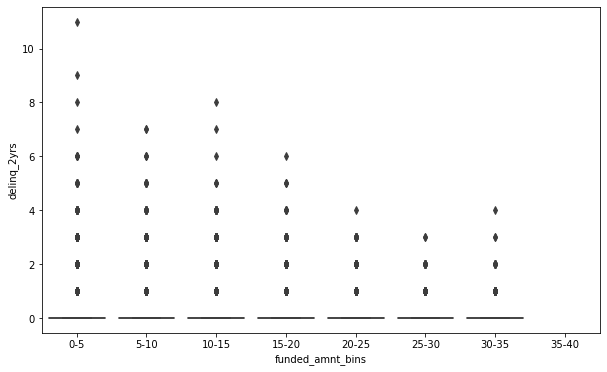

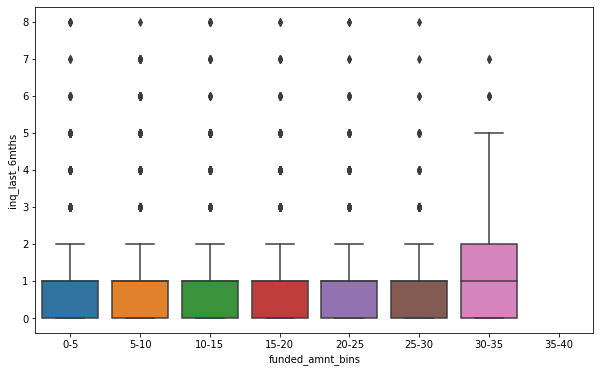

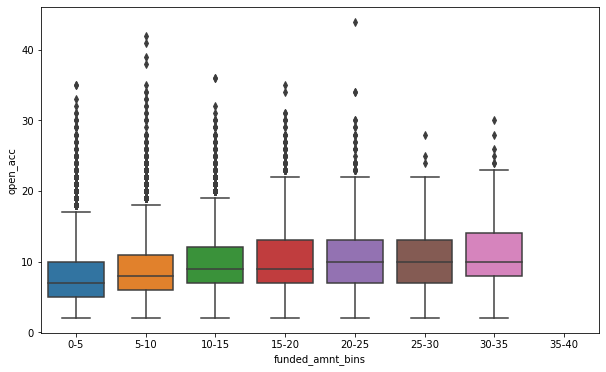

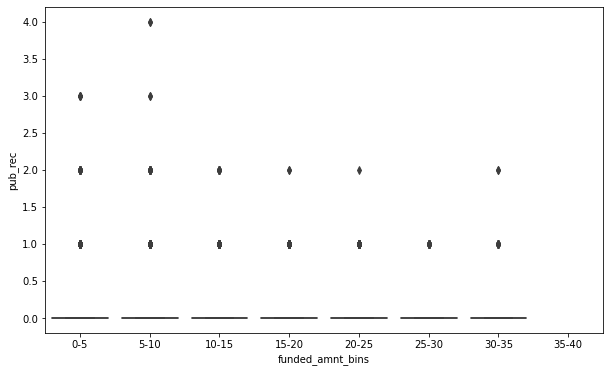

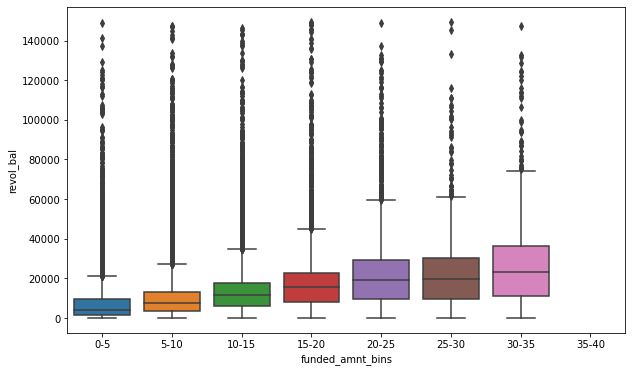

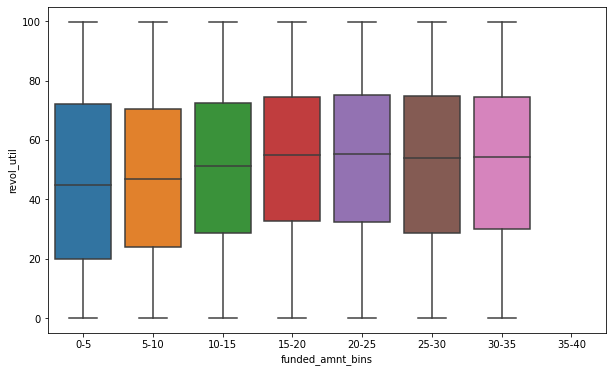

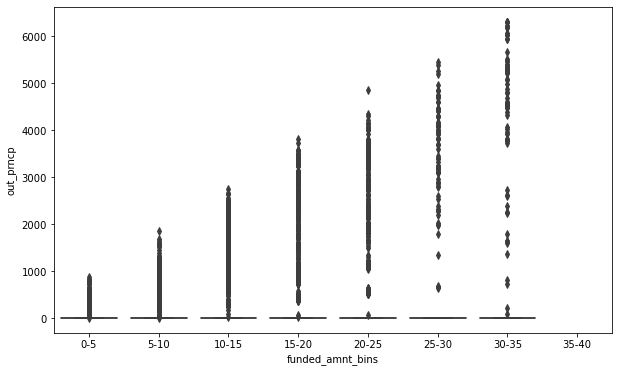

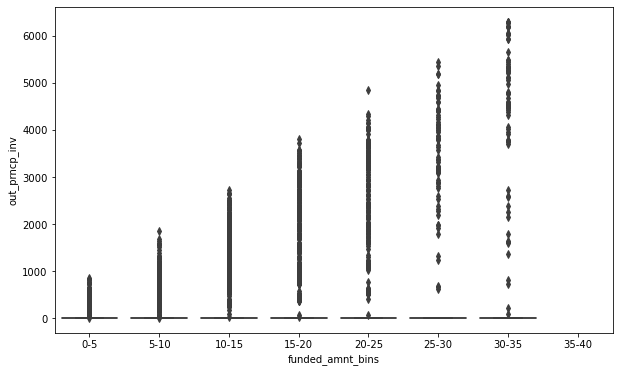

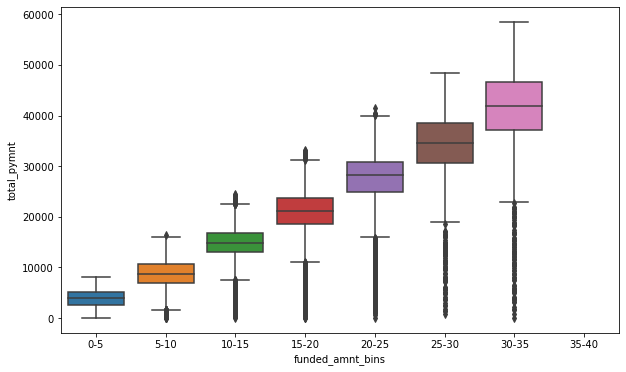

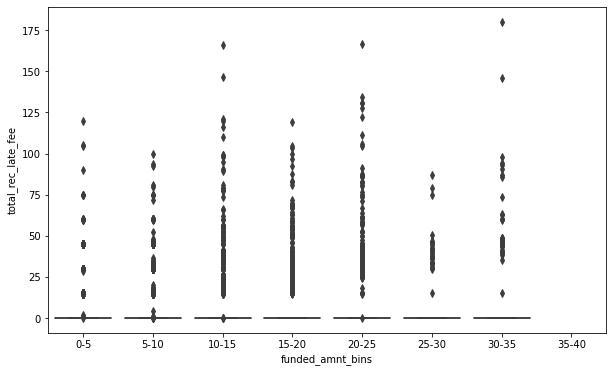

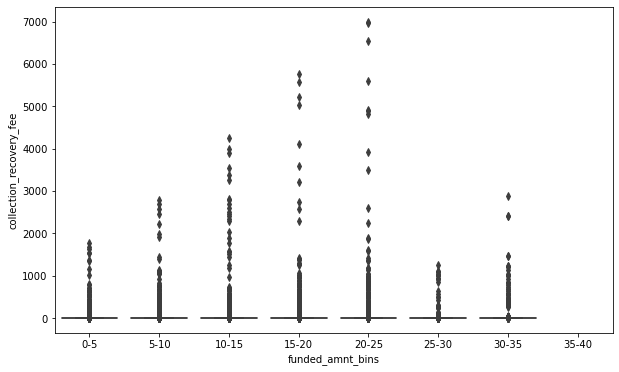

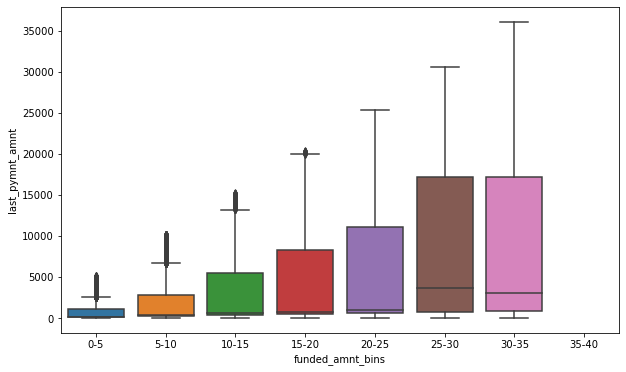

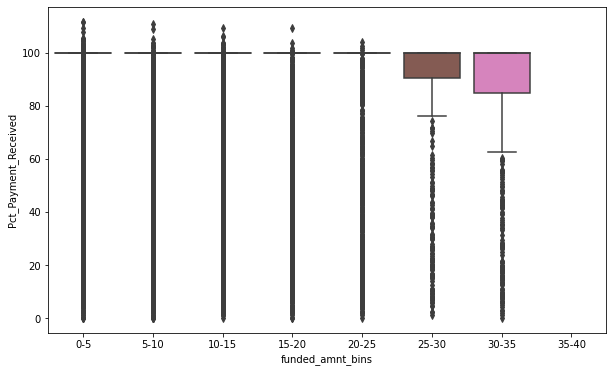

In [105]:
for col in df_numeric.columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(x="funded_amnt_bins", y=col,
                data=df)
    plt.show()

#### <font color="asparagus"> *Observations and Comments*:<font> 
$\Rightarrow$ <font color="asparagus"> Higher the funded amount, higher is the interest rate as well.<br>$\Rightarrow$ When we look at the inquiries made in the last 6 months vs funded_amnt_bins, 30000-35000 categories have only one outlier. Borrowers in the range 35000-40000 have not made any inquiries.<br>$\Rightarrow$ People that borow a high amount, tend to have more open accounts too.<font><br>

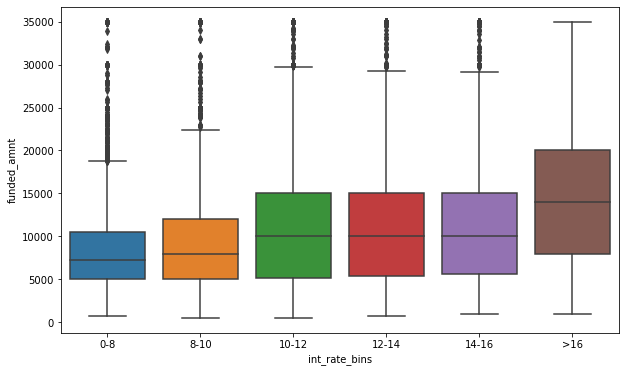

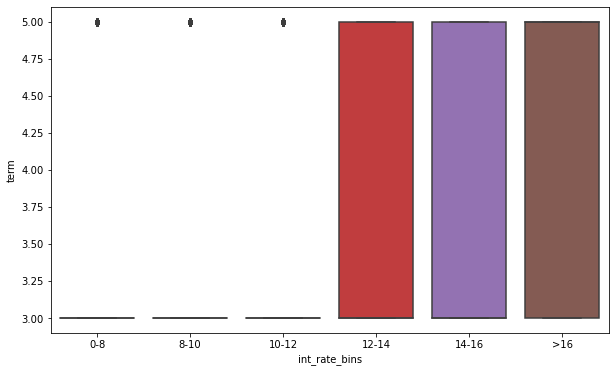

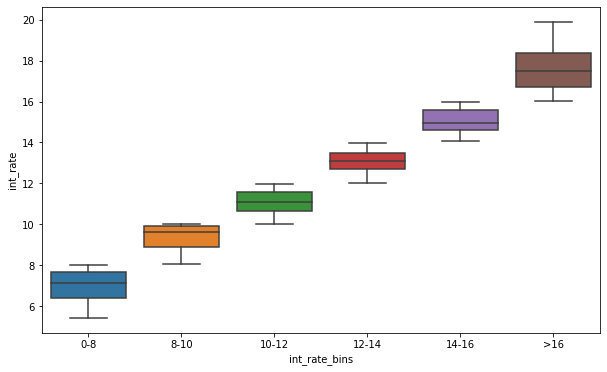

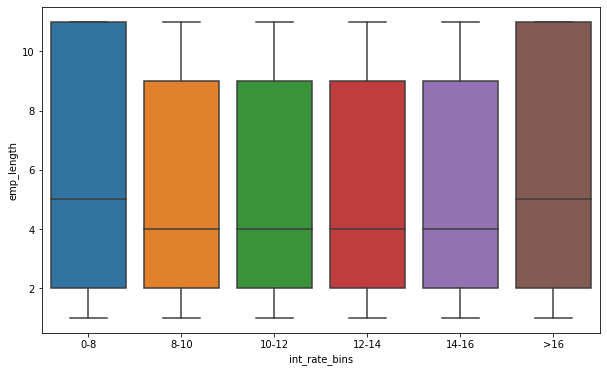

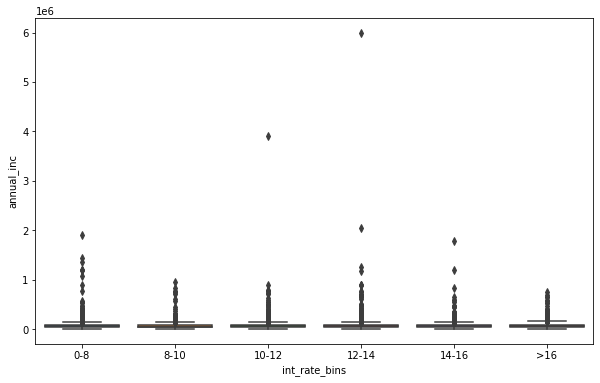

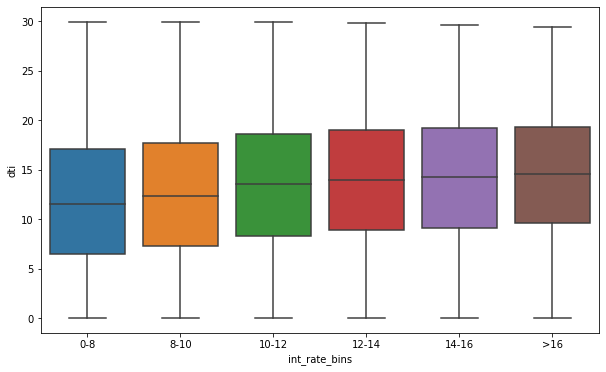

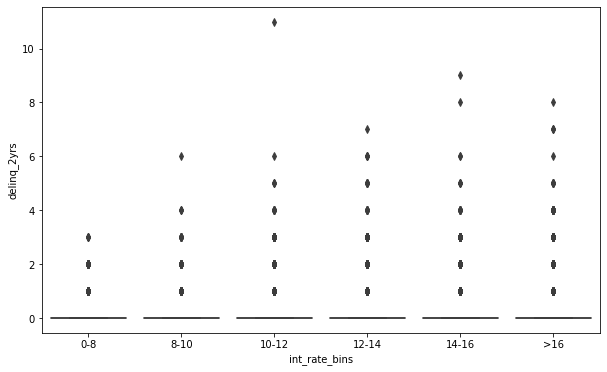

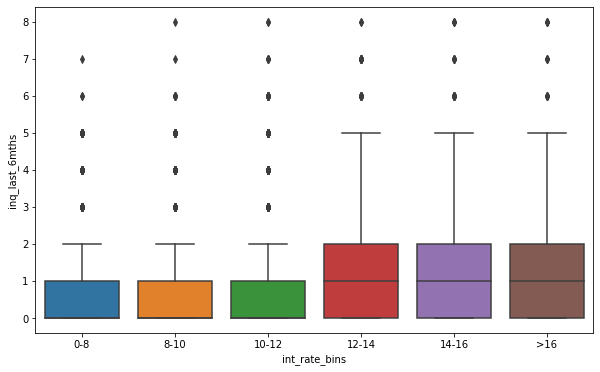

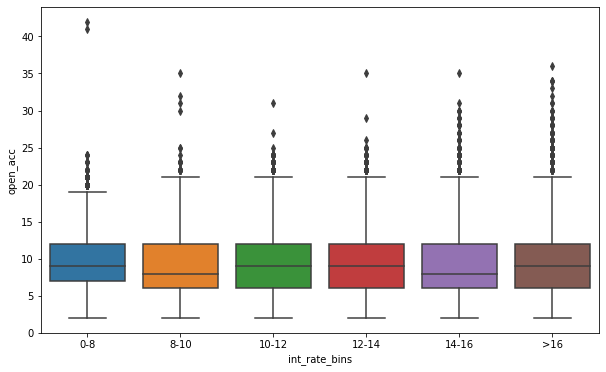

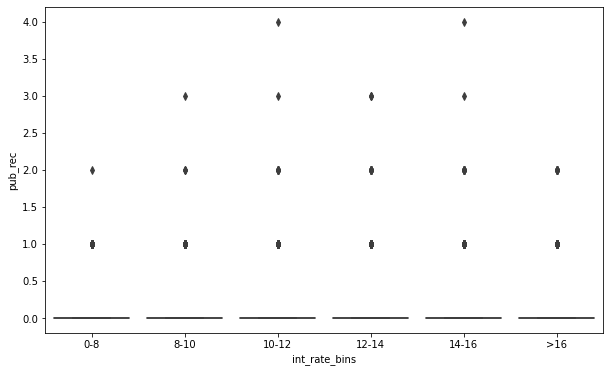

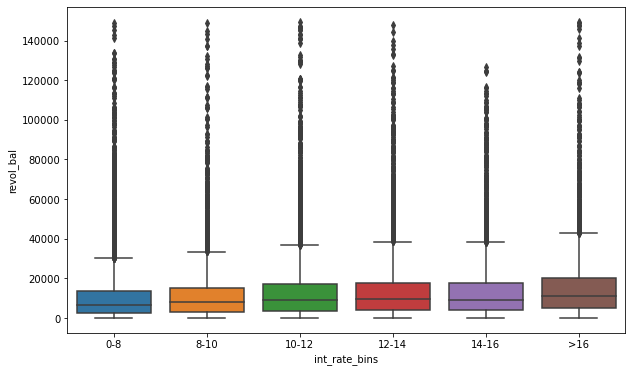

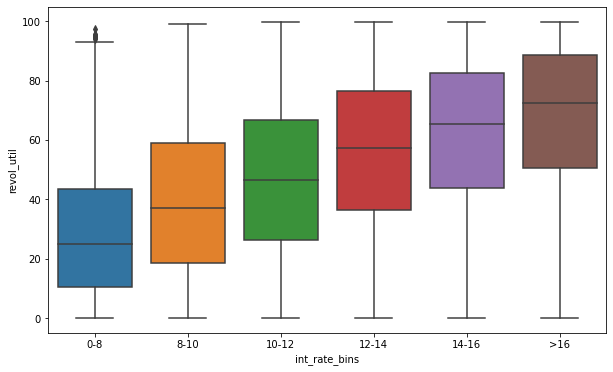

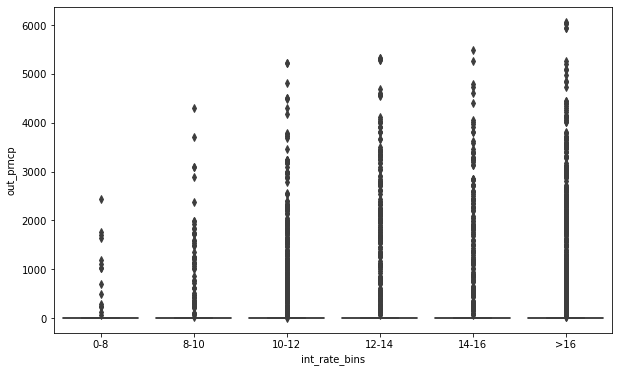

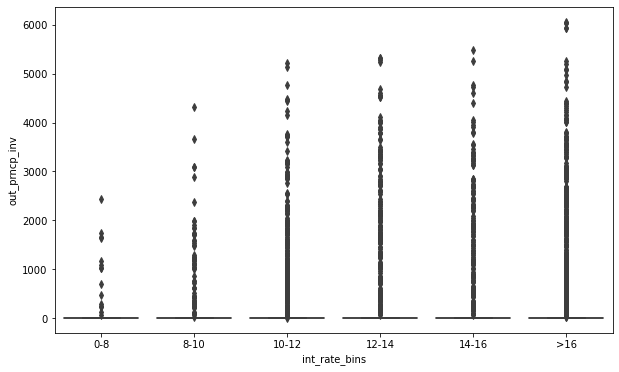

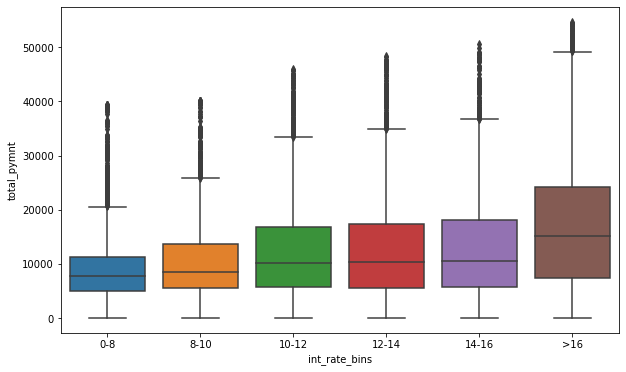

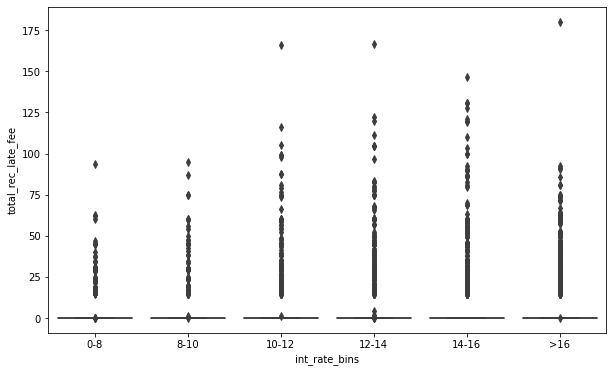

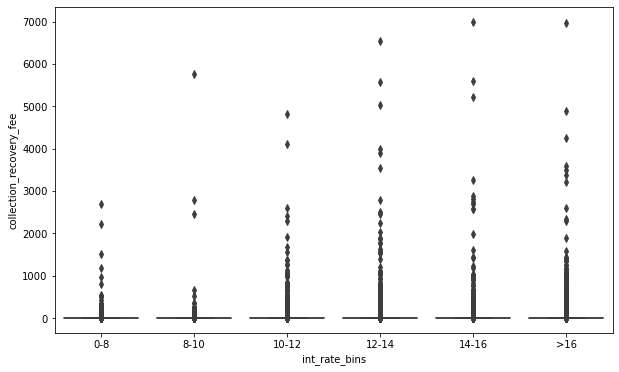

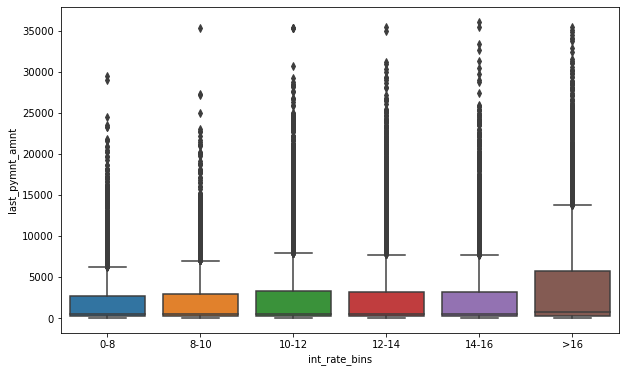

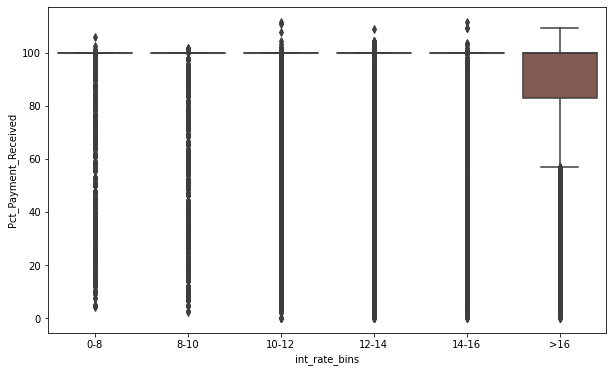

In [106]:
for col in df_numeric.columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(x="int_rate_bins", y=col,
                data=df)
    plt.show()

$\Rightarrow$ <font color="asparagus"> There are quite a few columns that seem to be heavily skewed towards one value. Eg: total_rec_late_fee, pub_rec, delinq_2yrs, annual_inc<br>
$\Rightarrow$ <font color="asparagus"> An IQR analysis will help us get a sense of the number of outliers 

### <font color='skyblue'>  II.7.2. IQR Analysis<font>

In [107]:
column_quantile_info ={}
for col in df_numeric.columns:
    Q1 = np.quantile(df[col], 0.25)
    Q2 = np.quantile(df[col], 0.5)
    Q3 = np.quantile(df[col], 0.75)
    Q4 = np.quantile(df[col], 0.99)
    Q5 = np.quantile(df[col], 0.01)
    IQR = Q3 - Q1
    column_quantile_info[col] = [Q1, Q2, Q3, IQR, Q3 + 1.5*IQR, Q1 - 1.5*IQR, Q4, Q5]

$\Rightarrow$ <font color="asparagus"> Let's just say outliers are those that are in the top 1% or bottom 1 %

In [108]:
upper_outlier_in_every_column = {}

In [109]:
for col in df_numeric.columns:
    #print((np.where(df[col] > column_quantile_info[col][6])))
    upper_outlier_in_every_column[col] = np.where(df[col] > column_quantile_info[col][6])

In [110]:
for col in df_numeric.columns:
    print(len(upper_outlier_in_every_column[col][0]))

0
0
390
0
398
396
322
260
372
60
398
398
398
398
398
398
398
398
79


$\Rightarrow$ <font color="asparagus"> That's a lot of outliers in every column. Let's try to see if there are any common rows among all columns <font>

In [111]:
common = np.intersect1d(upper_outlier_in_every_column["int_rate"], upper_outlier_in_every_column["last_pymnt_amnt"])

In [112]:
for col in df_numeric.columns:
    if len(upper_outlier_in_every_column[col][0]) > 300:
        common = np.intersect1d(common, upper_outlier_in_every_column[col][0])
        print(col, ": ", common)

int_rate :  [ 1156  1372  1482  1715  1799  1839  2157  2282  2654  2775  3308  3374
  3783  3901  4728  4817  4875  5168  5310  5432  5785  5966  6338  6456
  6485  6993  7764  7910 10146 10703 11582 14131 18893]
annual_inc :  [3783 3901 5168]
dti :  []
delinq_2yrs :  []
open_acc :  []
revol_bal :  []
revol_util :  []
out_prncp :  []
out_prncp_inv :  []
total_pymnt :  []
total_rec_late_fee :  []
collection_recovery_fee :  []
last_pymnt_amnt :  []


In [113]:
common

array([], dtype=int64)

In [114]:
lower_outlier_in_every_column = {}

In [115]:
for col in df_numeric.columns:
    #print((np.where(df[col] > column_quantile_info[col][6])))
    lower_outlier_in_every_column[col] = np.where(df[col] < column_quantile_info[col][7])

In [116]:
for col in df_numeric.columns:
    print(len(lower_outlier_in_every_column[col][0]))

328
0
0
0
328
392
0
0
0
0
0
0
0
0
398
0
0
398
398


In [117]:
lower_common = lower_outlier_in_every_column["funded_amnt"][0]

In [118]:
for col in df_numeric.columns:
    if len(lower_outlier_in_every_column[col][0]) > 300:
        lower_common = np.intersect1d(lower_common, lower_outlier_in_every_column[col][0])
        print(col, ": ", lower_common)

funded_amnt :  [   15   422   799  1390  1456  1675  1831  1880  1924  2140  2352  2691
  2740  2748  2842  2880  2944  3214  3668  3743  3822  3878  3950  4405
  4479  4535  4720  4890  4894  5487  5983  6017  6026  6062  6327  6391
  6392  6472  6635  6759  7089  7408  7434  7548  7984  7992  8008  8017
  8217  8308  8337  8806  9139  9245  9718  9973 10422 10452 10793 10816
 10839 11333 11421 11450 11572 11742 11991 12111 12238 12282 12318 12339
 12390 12454 12563 12957 12964 13187 13330 13379 13380 13629 13665 13721
 13726 13854 13956 13962 14113 14256 14261 14436 14442 14466 14500 14623
 14638 14698 14839 14949 15056 15085 15131 15206 15299 15517 15859 15902
 16034 16093 16277 16329 16485 16582 16790 16832 16858 16879 16894 16944
 17064 17137 17219 17330 17357 17513 18087 18303 18315 18389 18818 19035
 19721 19751 19951 20017 20209 20342 20350 20729 20772 20781 20960 21136
 21145 21171 21245 21285 21296 21535 22079 22202 22246 22337 22412 22593
 22596 22720 23006 23081 23232 23314

In [119]:
lower_common

array([], dtype=int64)

$\Rightarrow$ <font color="asparagus"> There are no common rows among all these columns. Let us leave them in because dropping so many columns will shrink the data drastically <font>

# <font color='goldenrod'> III. Data Analysis </font>

### <font color='skyblue'>  III.1. Univariate analysis<font>

#### <font color="asparagus"> *Observations and Comments*:<font><br>
$\Rightarrow$ <font color="asparagus">We already know many statistics of each variable because of the various boxplots from earlier. So let's just jump into segmented univariate analysis.<br> $\Rightarrow$ We will groupby certain categorical columns and analyze other numeric columns <font>

In [120]:
df.columns

Index(['funded_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state',
       'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_rec_late_fee', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'emp_length_bins', 'annual_inc_bins', 'funded_amnt_bins',
       'int_rate_bins', 'Pct_Payment_Received'],
      dtype='object')

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   funded_amnt              39717 non-null  int64   
 1   term                     39717 non-null  int32   
 2   int_rate                 39717 non-null  float64 
 3   grade                    39717 non-null  string  
 4   sub_grade                39717 non-null  string  
 5   emp_title                37258 non-null  string  
 6   emp_length               39717 non-null  int32   
 7   home_ownership           39717 non-null  string  
 8   annual_inc               39717 non-null  float64 
 9   verification_status      39717 non-null  string  
 10  issue_d                  39717 non-null  string  
 11  loan_status              39717 non-null  string  
 12  purpose                  39717 non-null  string  
 13  title                    39717 non-null  string  
 14  zip_co

In [123]:
cat_cols = ["grade", "sub_grade", "term", "home_ownership", 
            "verification_status", "loan_status", 
            "purpose", "zip_code", "addr_state", "annual_inc_bins", 
            "funded_amnt_bins", "int_rate_bins", "emp_length_bins"]

In [124]:
cont_cols = [col for col in df.columns if col not in cat_cols]

$\Rightarrow$ <font color="asparagus"> Grouping by loan status

In [125]:
df.groupby(by="loan_status").median()

,funded_amnt,term,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,out_prncp,out_prncp_inv,total_pymnt,total_rec_late_fee,collection_recovery_fee,last_pymnt_amnt,Pct_Payment_Received
loan_status,,,,,,,,,,,,,,,,,,,
Charged Off,"10,000.00",3.00,13.61,5.00,"53,000.00",14.29,0.00,1.00,8.00,0.00,"9,211.00",58.20,0.00,0.00,"4,839.00",0.00,2.51,238.25,36.66
Current,"15,225.00",5.00,14.65,7.00,"65,000.00",15.05,0.00,0.00,9.00,0.00,"12,627.50",54.95,"1,521.03","1,500.78","20,370.96",0.00,0.00,369.56,89.22
Fully Paid,"9,200.00",3.00,11.49,4.00,"60,000.00",13.20,0.00,1.00,9.00,0.00,"8,682.50",47.50,0.00,0.00,"10,687.16",0.00,0.00,863.68,100.00


#### I. Charged Off:
1. Cannot comment much on the funded_amnt. There doesn't seem to be a pattern. It roughly hovers around 10k.
2. The interest rate is the second highest. From our previous analysis in <font color='skyblue'>  II.7.1. Box Plots<font>, higher annual income borrowers tend to borrow more and for such cases, the interest rate is high. 
3. The annual income is coming out to be the lowest among the three loan_status' categories.  
4. The total_pymnt column understandably has lowest among the categories indicating that the borrower has not been making enough payments. You can have a look at the percentage of payment received so far. It is 36.66%. We had already identified this as an indicator for loan defaults.
5. recoveries: This is applicable to only charged off borrowers. Hence we see non-zero number under charged off cat, and zeros in the other categories. 
6. last_pymnt_amnt: Is the lowest for this category. 
7. Also the median termYrs is 3.

#### II. Current:
1. The following params are the highest among the three:
- funded_amnt, int_rate, installment, annual_inc
- dti: This will be high here since it is the ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
2. The outstanding principal for portion of total amount funded by investors is non-zero only for this category.
3. "total" columns are the highest again
4. The last payment amount is not that high: Right in the center
5. Annual inc: higest of the three. 

#### III. Fully Paid: <font color='red'>  TO DO!<font>
1. last_pymnt_amount highest among the three
2. Annual inc: second highest
3. funded_amnt: Lowest
4. int_rate: lowest

In [126]:
cat_cols

['grade',
 'sub_grade',
 'term',
 'home_ownership',
 'verification_status',
 'loan_status',
 'purpose',
 'zip_code',
 'addr_state',
 'annual_inc_bins',
 'funded_amnt_bins',
 'int_rate_bins',
 'emp_length_bins']

<font color='red'>  TO DO! A better way to print the grouped df<font>

In [128]:
for col in cat_cols:
    if col not in ["sub_grade", "loan_status"]:
        print(df.groupby(by=col).median())

       funded_amnt  term  int_rate  emp_length  annual_inc   dti  delinq_2yrs  \
grade                                                                           
A         7,200.00  3.00      7.49        5.00   57,600.00 11.50         0.00   
B        10,000.00  3.00     10.99        5.00   57,989.50 13.53         0.00   
C         9,600.00  3.00     13.49        4.00   56,000.00 14.08         0.00   
D        10,000.00  3.00     15.65        4.00   59,000.00 14.27         0.00   
E        15,000.00  5.00     17.56        5.00   65,000.00 14.48         0.00   
F        17,500.00  5.00     19.47        5.00   72,000.00 14.68         0.00   
G        20,000.00  5.00     21.14        5.00   80,000.00 14.63         0.00   

       inq_last_6mths  open_acc  pub_rec  revol_bal  revol_util  out_prncp  \
grade                                                                        
A                0.00      9.00     0.00   6,777.00       25.80       0.00   
B                0.00      9.00     

### Some pivot tables.
> looking at grade wise pivots. values will still be funded_amount

In [ ]:
df_bak.pivot_table(index="grade",columns=["loan_status"], values="funded_amnt", aggfunc="median")

### It is evident from the table below that worse the credit rating of a person, more money they will borrow. 
* Grade G's borrowed amount ~18-20k.
* Grade A's borrowed amount ~ 7.5k to 10k.
- May be people with credit ratings live a more risky life? : )

In [ ]:
df_bak.pivot_table(index="grade",columns=["loan_status"], values="funded_amnt", aggfunc="mean")

### Let's get some numbers
1. How many people of a certain grade borrowed
2. How many of them defaulted, how many are currently paying/have fully paid

### Analyzing charged off borrowers alone. 



In [ ]:
df_chargedOff = df_bak[df_bak["loan_status"] == "Charged Off"].groupby(by="grade").size()

In [ ]:
df_chargedOff

In [ ]:
total_charged_off = []
for i in range(df_chargedOff.shape[0]):
    total_charged_off.append(df_chargedOff[i])

In [ ]:
total_charged_off

In [ ]:
df_current = df_bak[df_bak["loan_status"] == "Current"].groupby(by="grade").size()

In [ ]:
df_current

In [ ]:
total_current = []
for i in range(df_current.shape[0]):
    total_current.append(df_current[i])

In [ ]:
df_fullyPaid = df_bak[df_bak["loan_status"] == "Fully Paid"].groupby(by="grade").size()

In [ ]:
df_fullyPaid

In [ ]:
total_fullyPaid = []
for i in range(df_fullyPaid.shape[0]):
    total_fullyPaid.append(df_fullyPaid[i])

In [ ]:
df_totalPeopleGradeWise = df_bak.groupby(by="grade").size()

In [ ]:
df_totalPeopleGradeWise

In [ ]:
total_totalGradeWise = []
for i in range(df_totalPeopleGradeWise.shape[0]):
    total_totalGradeWise.append(df_totalPeopleGradeWise[i])

## Pie chart please : )

In [ ]:
"""l = [1,2,3]
m = [4,5,6]
n=[7,8,9]
r = {}
label = ["a","b","c"]
count = 0
for i,j,k in zip(l,m,n):
    r[label[count]] = round([i,j,k]/
    count += 1
    """

In [ ]:
gradewise_dist ={}
grade_labels = sorted(df.grade.unique())
cnt = 0
for ch,cur,fPaid,totalGWise in zip(total_charged_off,total_current, total_fullyPaid, total_totalGradeWise):
    gradewise_dist[grade_labels[cnt]] = [round(100 *ch/totalGWise,2), round(100 *cur/totalGWise,2), round(100 *fPaid/totalGWise,2)]
    cnt += 1

In [ ]:
grade_labels

In [ ]:
gradewise_dist

## Charged Off column alone observation:
1. Looking at this, it seems B,C D are more likely to default, it goes against our assumption: "people with lower credit score are more likely to default". 
2. It seems to be deceptive. We must see gradewise percent of people that have defaulted. 

In [ ]:
plt.figure(figsize=(10,10))
plt.pie(df_chargedOff,labels=grade_labels,autopct='%.0f%%', textprops={'color':"w"})
plt.show()

In [ ]:
#plt.figure(figsize=(10,15))
for label in grade_labels:
    plt.pie(gradewise_dist[label],labels=["Charged Off", "Current", "Fully Paid"], autopct='%.0f%%', textprops={'color':"w"})
    plt.title(f"Grade {label}")
    plt.show()


In [ ]:
df_bak.pivot_table(index="home_ownership",columns=["loan_status"], values="funded_amnt", aggfunc="mean")

In [ ]:
df_bak.pivot_table(index=["home_ownership", "emp_length2"],columns=["loan_status"], values="funded_amnt", aggfunc="mean")

In [ ]:
df.inq_last_6mths.value_counts()

In [ ]:
pd.set_option('display.max_rows', 1000)

In [ ]:
df_bak.pivot_table(index=["addr_state", "zip_code"],columns=["loan_status"], values="funded_amnt", aggfunc="median")

In [ ]:
(df[df.emp_title == "US Army"]["addr_state"]).value_counts()

In [ ]:
df.zip_code.value_counts()

In [ ]:
df_bak

In [ ]:
df_bak.pivot_table(index="purpose",columns=["loan_status"], values="funded_amnt", aggfunc="mean")

## For the people who defaulted, let's look at the purpose distribution

In [ ]:
df_chargedOff = df[df.loan_status == "Charged Off"]

In [ ]:
df_purpose = df_chargedOff.groupby(by="purpose").size()

In [ ]:
label = df_bak["purpose"].unique()

In [ ]:
label = sorted(label)

In [ ]:
label

In [ ]:
plt.figure(figsize=(10,10))
plt.pie(df_purpose,labels=label, autopct='%.0f%%', textprops={'color':"w"})
plt.show()

* By looking at the charged off distribution alone, we can say that debt consolidation contributes to the most defaults. 
* Then again, we must look at the percentages of defaults within each category
### Histogram

In [ ]:
df.purpose.value_counts()

In [ ]:
#plt.hist(df_purpose,label=label)
plt.figure(figsize=(10,10))
ax = df_purpose.plot(kind="bar",color=["C0","C1","C2"])
plt.show()

In [ ]:
df.purpose.value_counts()

In [ ]:
df.purpose.value_counts().sort_index()

In [ ]:
total = []
for i in range(len(label)):
    total.append(df.purpose.value_counts().sort_index()[i])
    

In [ ]:
total

In [ ]:
chargedOff_total = []
for i in range(len(label)):
    chargedOff_total.append(df_purpose[i])

In [ ]:
chargedOff_total

In [ ]:
df_purpose

In [ ]:
res = [round((i/j)*100,2) for i,j in zip(chargedOff_total, total)]

In [ ]:
res= {}
cnt = 0
for i,j in zip(chargedOff_total,total):
    res[label[cnt]] = round((i/j)*100,2)
    cnt += 1

In [ ]:
res

In [ ]:
plt.figure(figsize=(10,15))
plt.pie(res.values(),labels=label, autopct='%.0f%%', textprops={"color": "w"})
plt.show()

* From the above pie chart, we can see that 7% of loans asked for debt consolidation were defaulted. 
* small_business contributes to more defaults: 13%. Which kind of makes sense, after all small business can be make or break
* Loans for car, wedding, credit_card repayment, major_purchase contribute to defaults the lowest. Home improvement is a close second